In [2]:
import sys
from pathlib import Path

# Add the notebooks directory to the path
sys.path.append(str(Path.cwd().parent))

from utils import time_filter, get_selected_pods
from charts import cpu_chart, cpu_chart_stacked, cpu_chart_nodes, memory_chart, memory_chart_stacked, memory_chart_nodes, gantt_chart, minio_charts, kafka_charts

import pandas as pd

experiment_name = "experiment06"

start_time = pd.Timestamp("2025-05-30 20:50:00").tz_localize("America/Sao_Paulo")
end_time = pd.Timestamp("2025-05-30 21:50:00").tz_localize("America/Sao_Paulo")

---

# Edge Data

In [32]:
base_path = f"../../data/raw/{experiment_name}/{experiment_name}_edge"
df_container_cpu_usage_seconds_total = pd.read_parquet(base_path + "/container_cpu_usage_seconds_total.parquet")
df_container_memory_usage_bytes = pd.read_parquet(base_path + "/container_memory_usage_bytes.parquet")
df_kube_pod_status_phase = pd.read_parquet(base_path + "/kube_pod_status_phase.parquet")

df_spark_application_running_count = pd.read_parquet(base_path + "/spark_application_running_count.parquet")
df_spark_application_start_latency_seconds_count = pd.read_parquet(base_path + "/spark_application_start_latency_seconds_count.parquet")

kafka_bytes_in = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_bytesin_total.parquet")
kafka_bytes_out = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_bytesout_total.parquet")
kafka_messages_in = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_messagesin_total.parquet")
kafka_requests = pd.read_parquet(base_path + "/kafka_network_requestmetrics_requests_total.parquet")
kafka_requests_errors = pd.read_parquet(base_path + "/kafka_network_requestmetrics_errors_total.parquet")

# === Load all MinIO metric CSVs ===
df_minio_incoming = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_incoming_total.parquet').reset_index(), start_time, end_time)
df_minio_total = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_total.parquet').reset_index(), start_time, end_time)
df_minio_waiting = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_waiting_total.parquet').reset_index(), start_time, end_time)
df_minio_errors = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_errors_total.parquet').reset_index(), start_time, end_time)
df_minio_sent_bytes = time_filter(pd.read_parquet(base_path + '/minio_s3_traffic_sent_bytes.parquet').reset_index(), start_time, end_time)
df_minio_received_bytes = time_filter(pd.read_parquet(base_path + '/minio_s3_traffic_received_bytes.parquet').reset_index(), start_time, end_time)

df_container_cpu_usage_seconds_total = df_container_cpu_usage_seconds_total.reset_index()
df_container_memory_usage_bytes = df_container_memory_usage_bytes.reset_index()
df_kube_pod_status_phase = df_kube_pod_status_phase.reset_index()

kafka_bytes_in = kafka_bytes_in.reset_index()
kafka_bytes_out = kafka_bytes_out.reset_index()
kafka_messages_in = kafka_messages_in.reset_index()
kafka_requests = kafka_requests.reset_index()
kafka_requests_errors = kafka_requests_errors.reset_index()

df_container_cpu_usage_seconds_total = time_filter(df_container_cpu_usage_seconds_total, start_time, end_time)
df_container_memory_usage_bytes = time_filter(df_container_memory_usage_bytes, start_time, end_time)
df_kube_pod_status_phase = time_filter(df_kube_pod_status_phase, start_time, end_time)

kafka_bytes_in = time_filter(kafka_bytes_in, start_time, end_time)
kafka_bytes_out = time_filter(kafka_bytes_out, start_time, end_time)
kafka_messages_in = time_filter(kafka_messages_in, start_time, end_time)
kafka_requests = time_filter(kafka_requests, start_time, end_time)
kafka_requests_errors = time_filter(kafka_requests_errors, start_time, end_time)

selected_pods = get_selected_pods(df_kube_pod_status_phase)

# Filter distributed Minio
selected_pods = [
    pod for pod in selected_pods if not pod.startswith("minio-community")
]

NODE_CPU_LIMITS = {
    "flncpcsrv-k8s-w01": 400,
    "flncpcsrv-k8s-w02": 400,
    "flncpcsrv-k8s-w03": 400,
    "flncpcsrv-k8s-w04": 400,
}

NODE_MEMORY_LIMITS = {
    "flncpcsrv-k8s-w01": 16.384,  # 16 GiB
    "flncpcsrv-k8s-w02": 16.384,
    "flncpcsrv-k8s-w03": 16.384,
    "flncpcsrv-k8s-w04": 16.384,
}

df_kube_pod_status_phase = df_kube_pod_status_phase[df_kube_pod_status_phase["pod"].isin(selected_pods)]
df_container_cpu_usage_seconds_total_filtered = df_container_cpu_usage_seconds_total[df_container_cpu_usage_seconds_total["pod"].isin(selected_pods)]
df_container_memory_usage_bytes_filtered = df_container_memory_usage_bytes[df_container_memory_usage_bytes["pod"].isin(selected_pods)]
df_minio_incoming = df_minio_incoming[df_minio_incoming["pod"].isin(selected_pods)]
df_minio_total = df_minio_total[df_minio_total["pod"].isin(selected_pods)]
df_minio_waiting = df_minio_waiting[df_minio_waiting["pod"].isin(selected_pods)]
df_minio_errors = df_minio_errors[df_minio_errors["pod"].isin(selected_pods)]
df_minio_sent_bytes = df_minio_sent_bytes[df_minio_sent_bytes["pod"].isin(selected_pods)]
df_minio_received_bytes = df_minio_received_bytes[df_minio_received_bytes["pod"].isin(selected_pods)]

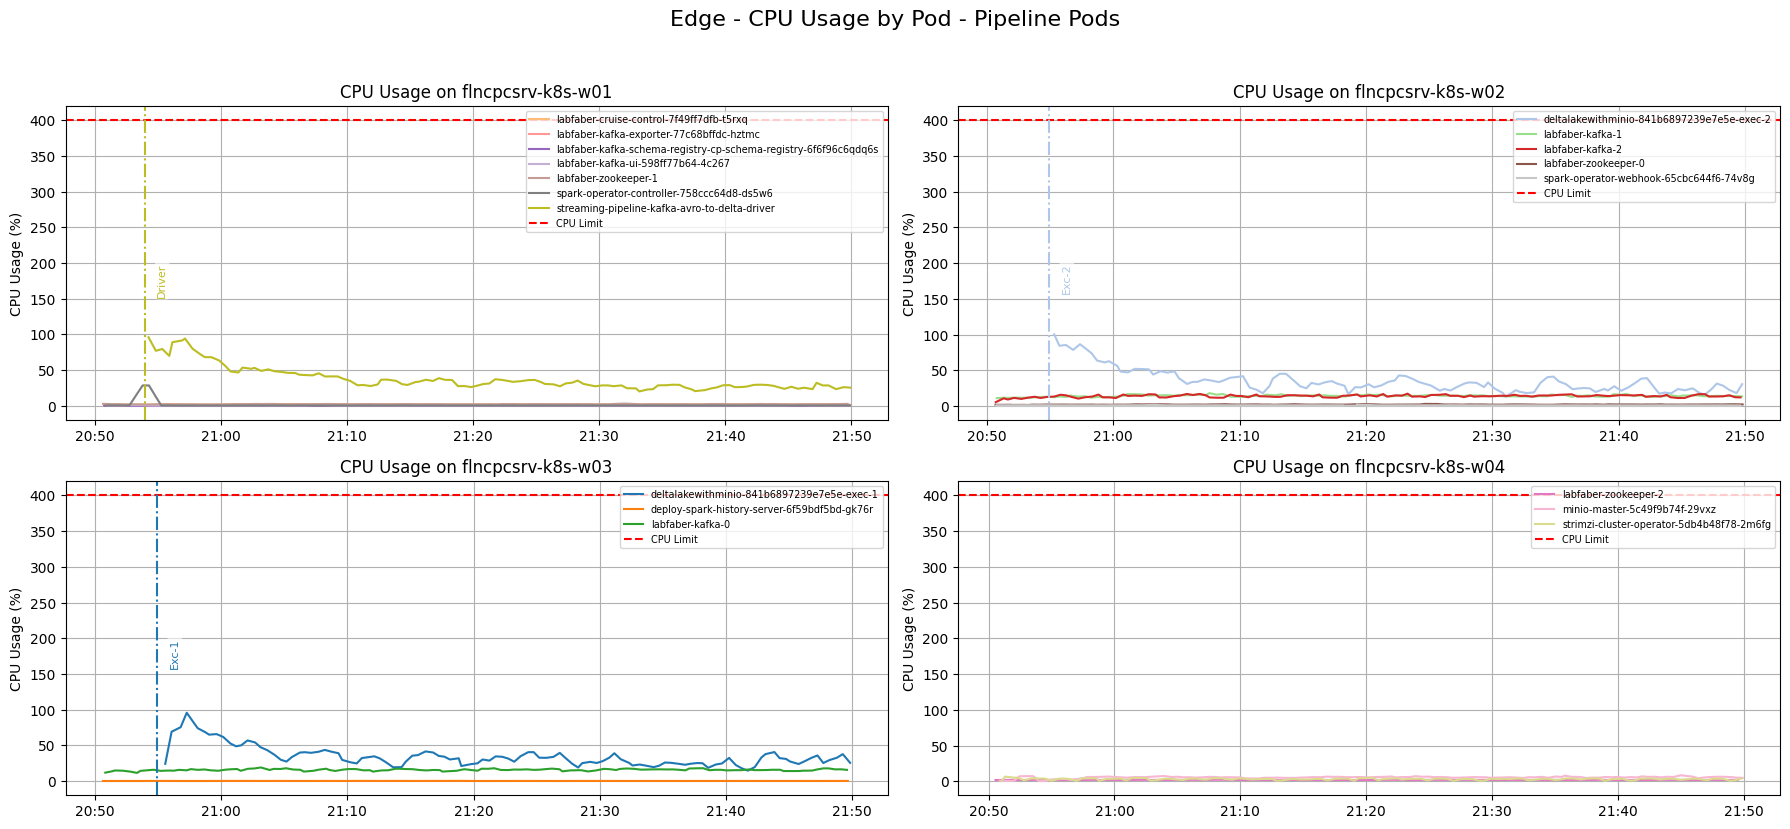

In [33]:
cpu_chart(df_container_cpu_usage_seconds_total_filtered, df_kube_pod_status_phase, title="Edge - CPU Usage by Pod - Pipeline Pods", node_cpu_limits=NODE_CPU_LIMITS)

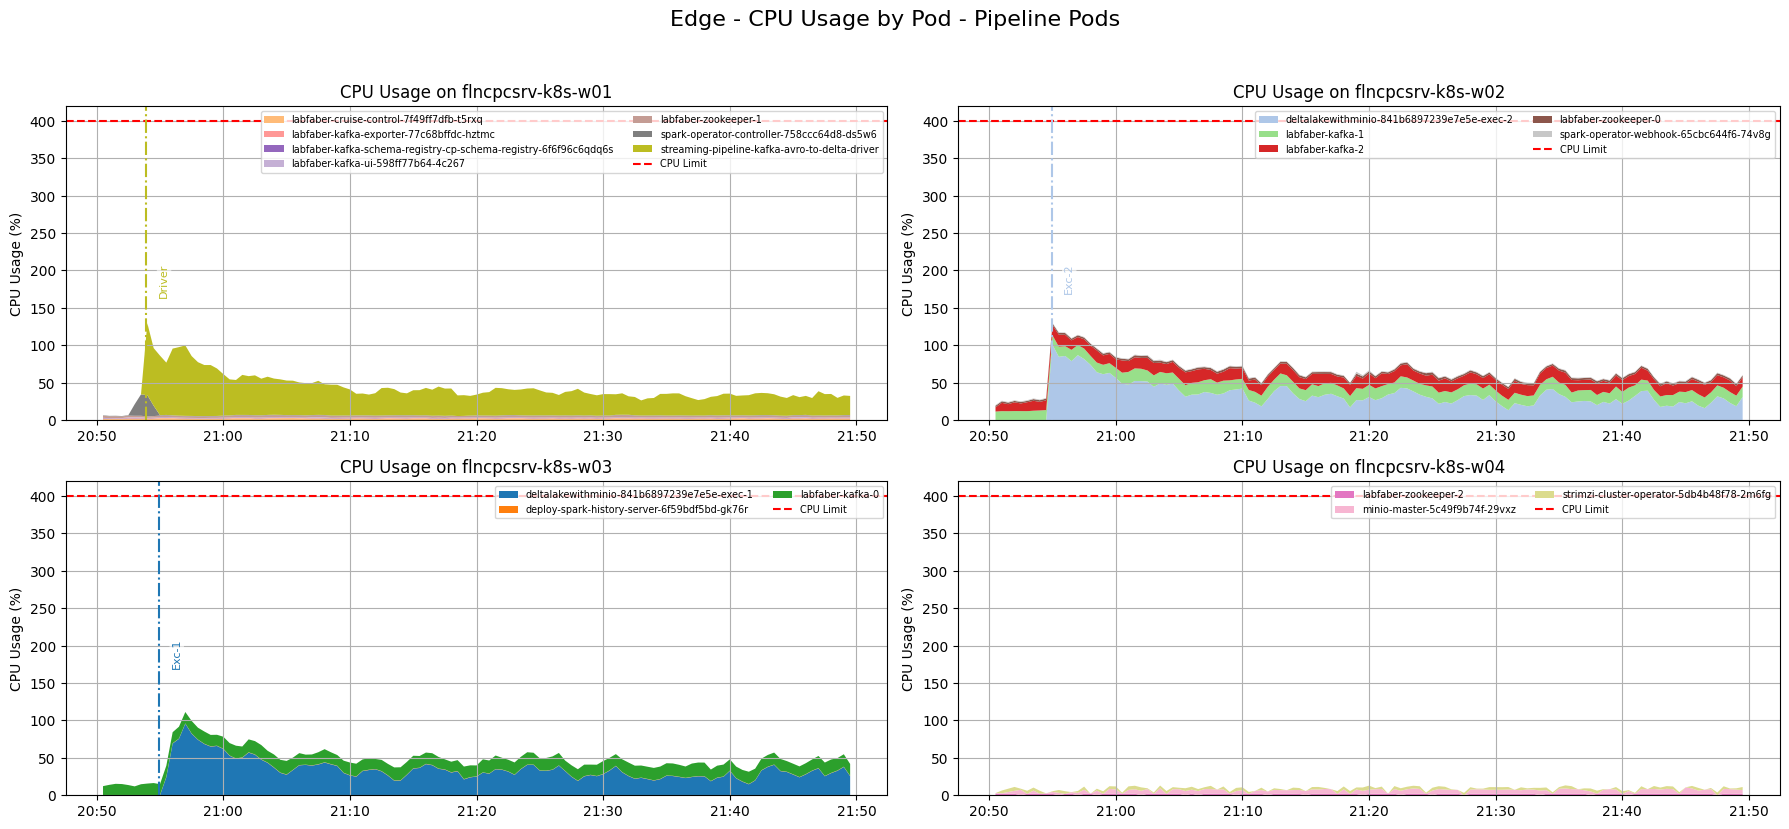

In [34]:
cpu_chart_stacked(df_container_cpu_usage_seconds_total_filtered, df_kube_pod_status_phase, title="Edge - CPU Usage by Pod - Pipeline Pods", node_cpu_limits=NODE_CPU_LIMITS)

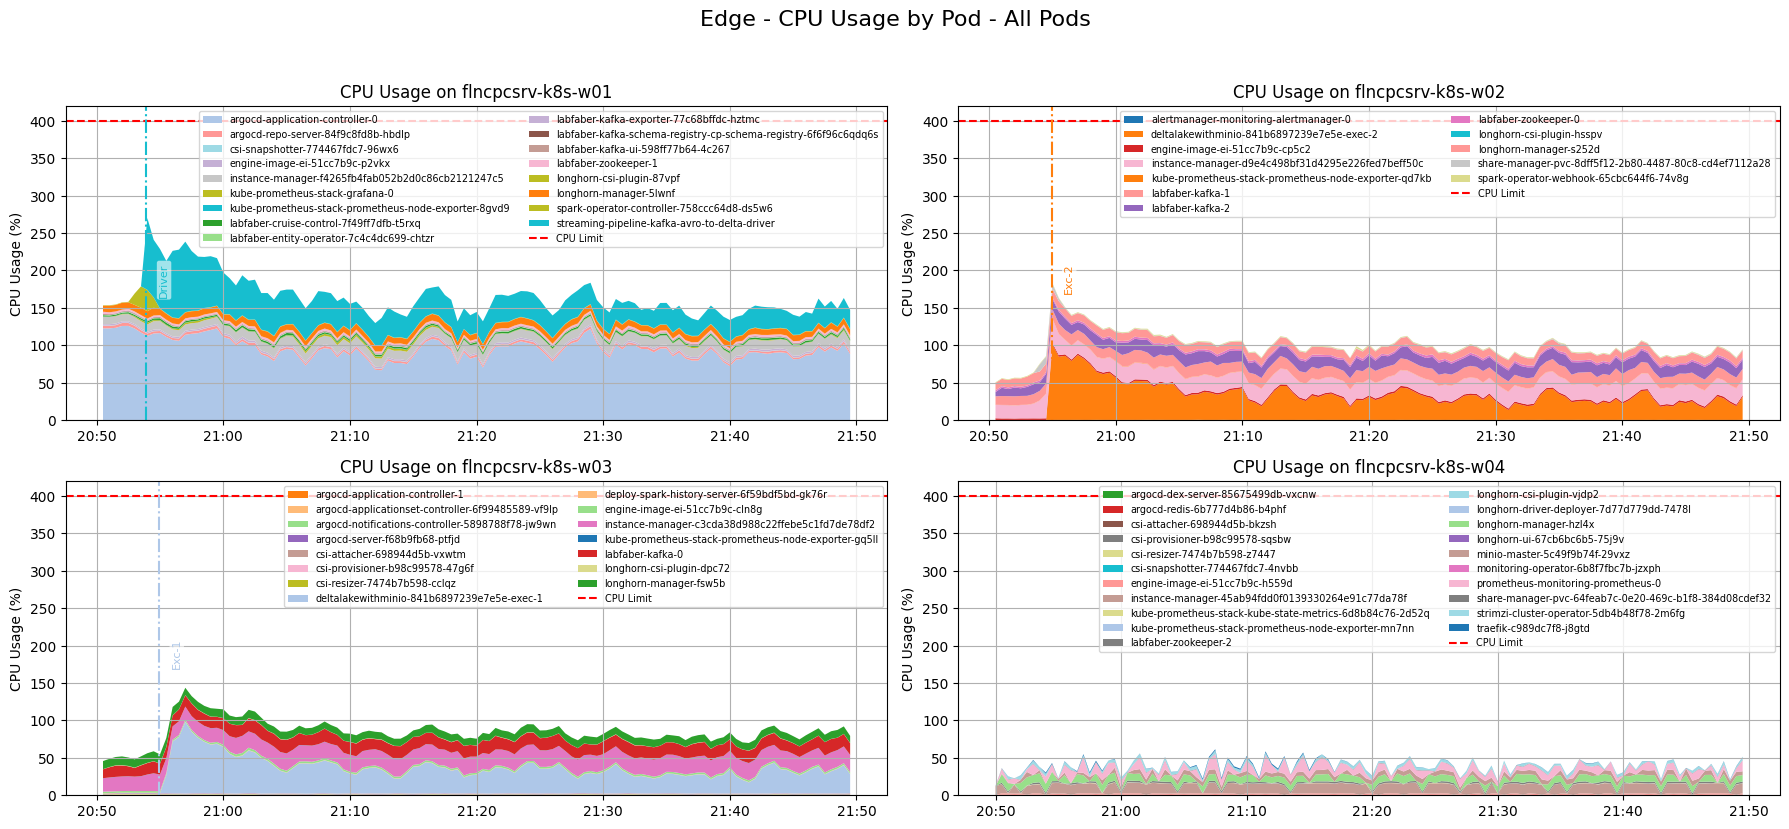

In [35]:
cpu_chart_stacked(df_container_cpu_usage_seconds_total, df_kube_pod_status_phase, title="Edge - CPU Usage by Pod - All Pods", node_cpu_limits=NODE_CPU_LIMITS)

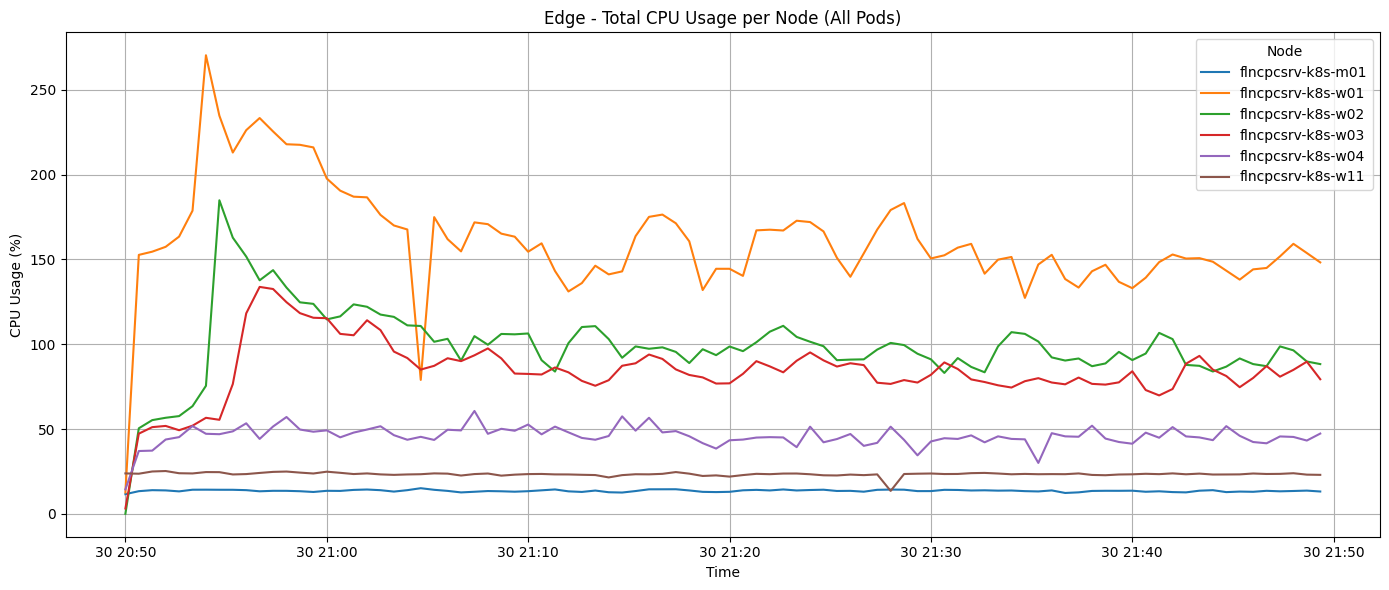

In [ ]:
cpu_chart_nodes(df_container_cpu_usage_seconds_total, "Edge - Total CPU Usage per Node (All Pods)")

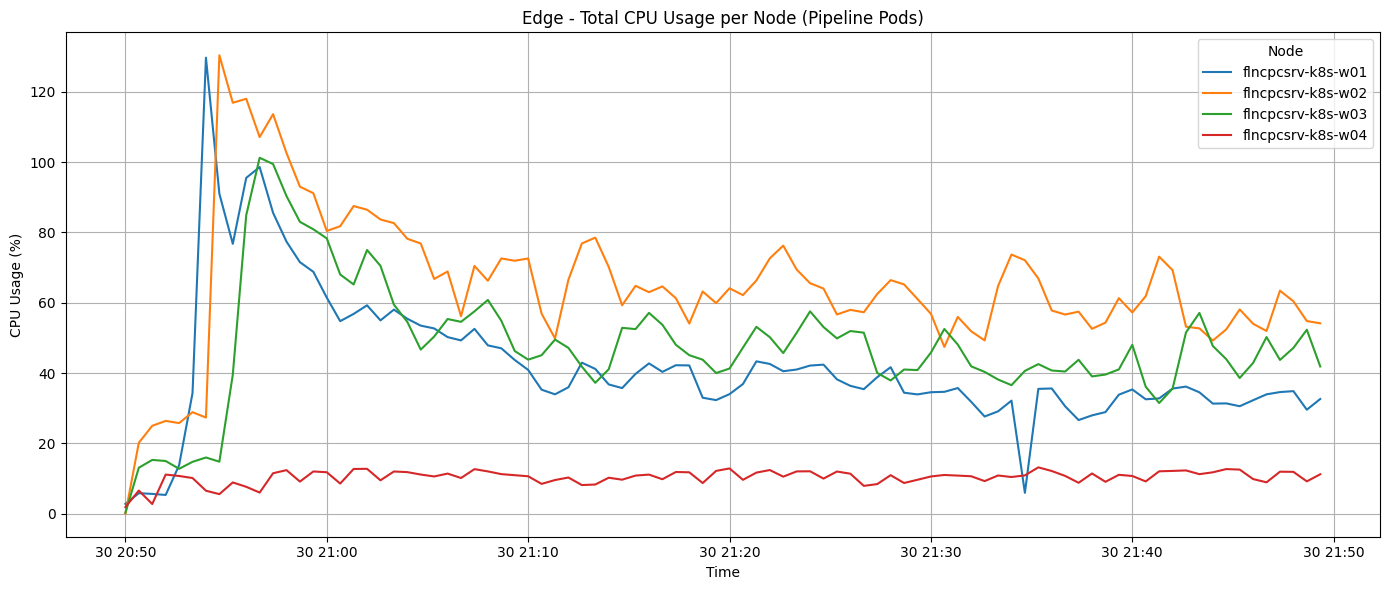

In [8]:
cpu_chart_nodes(df_container_cpu_usage_seconds_total_filtered, "Edge - Total CPU Usage per Node (Pipeline Pods)")

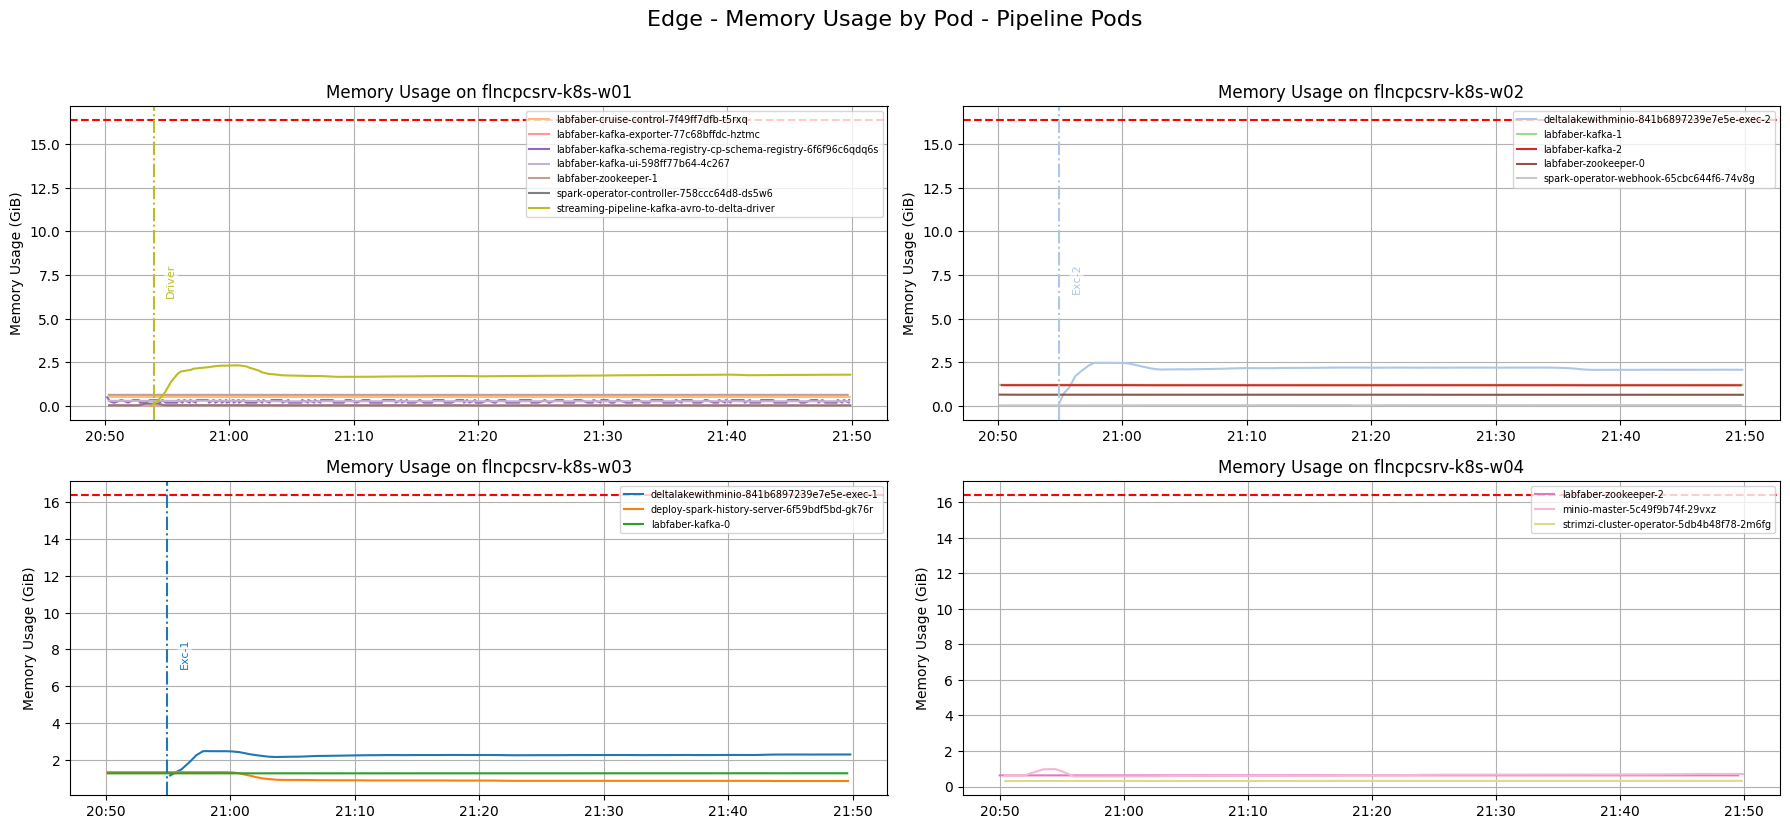

In [36]:
memory_chart(df_container_memory_usage_bytes_filtered, df_kube_pod_status_phase, title="Edge - Memory Usage by Pod - Pipeline Pods", node_memory_limits=NODE_MEMORY_LIMITS)

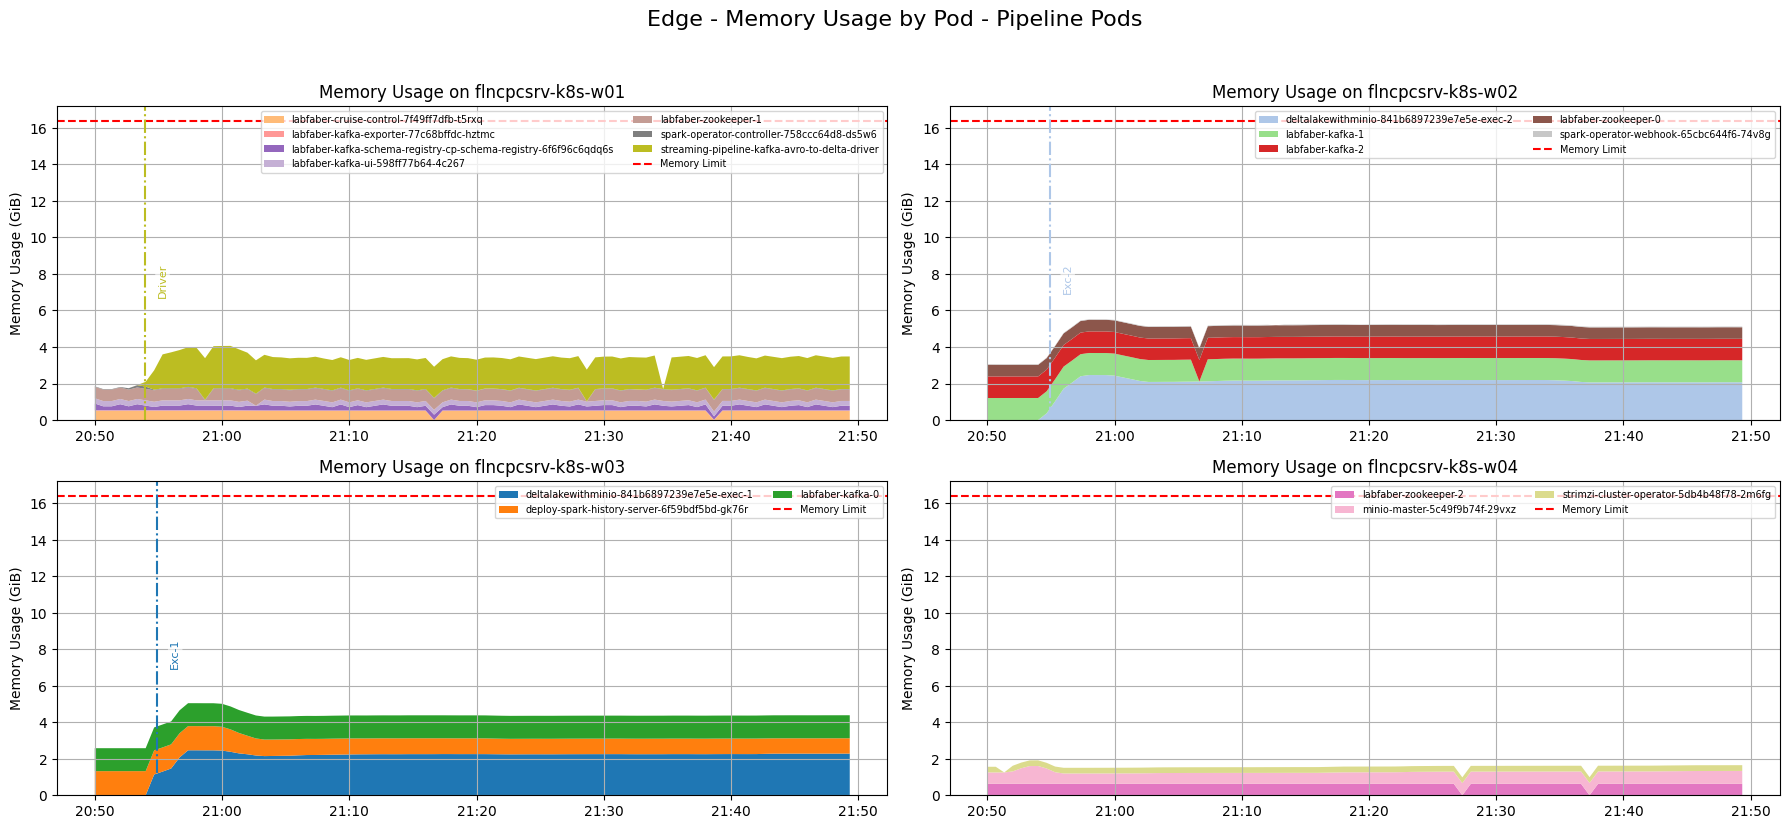

In [37]:
memory_chart_stacked(df_container_memory_usage_bytes_filtered, df_kube_pod_status_phase, title="Edge - Memory Usage by Pod - Pipeline Pods", node_memory_limits=NODE_MEMORY_LIMITS)

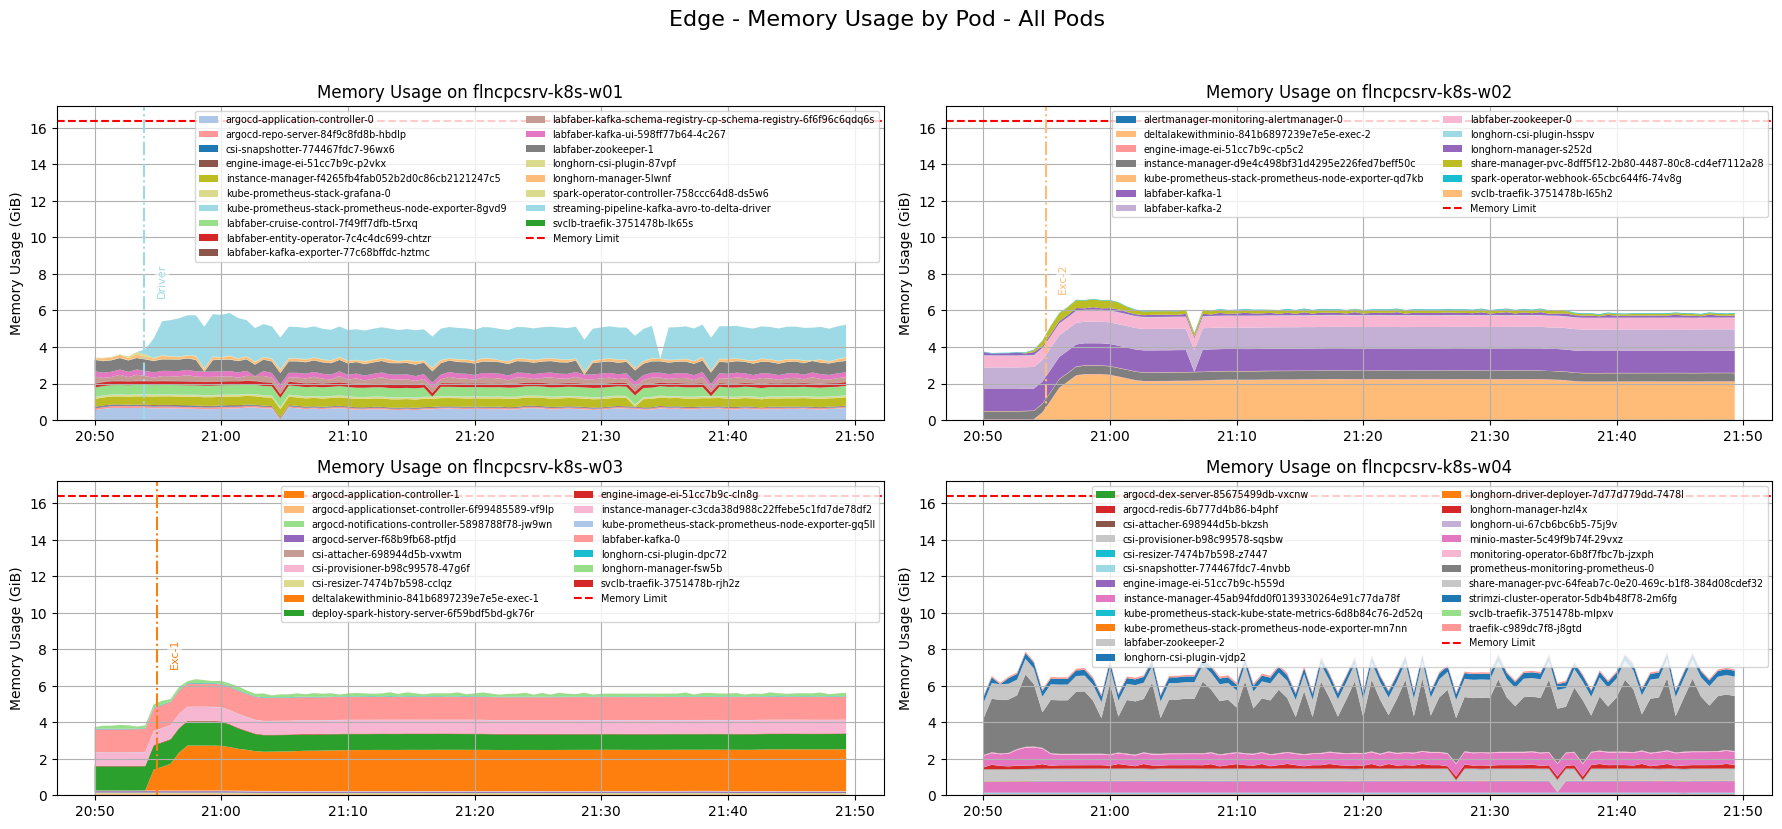

In [38]:
memory_chart_stacked(df_container_memory_usage_bytes, df_kube_pod_status_phase, title="Edge - Memory Usage by Pod - All Pods", node_memory_limits=NODE_MEMORY_LIMITS)

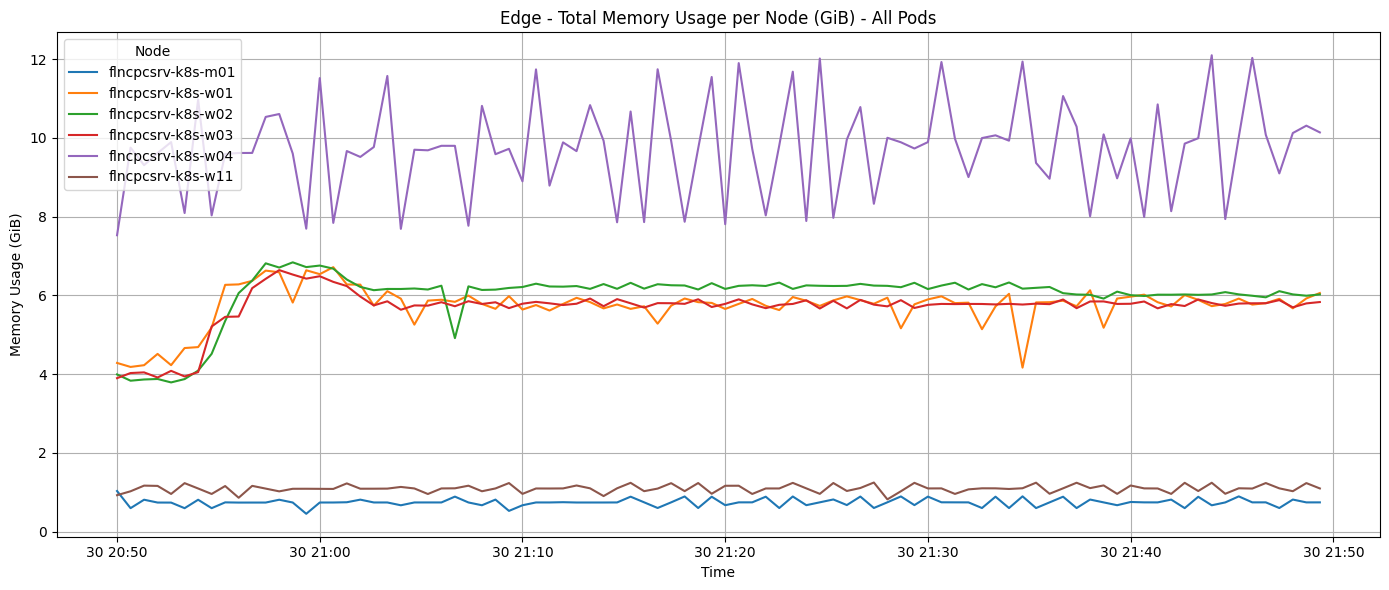

In [12]:
memory_chart_nodes(df_container_memory_usage_bytes, "Edge - Total Memory Usage per Node (GiB) - All Pods")

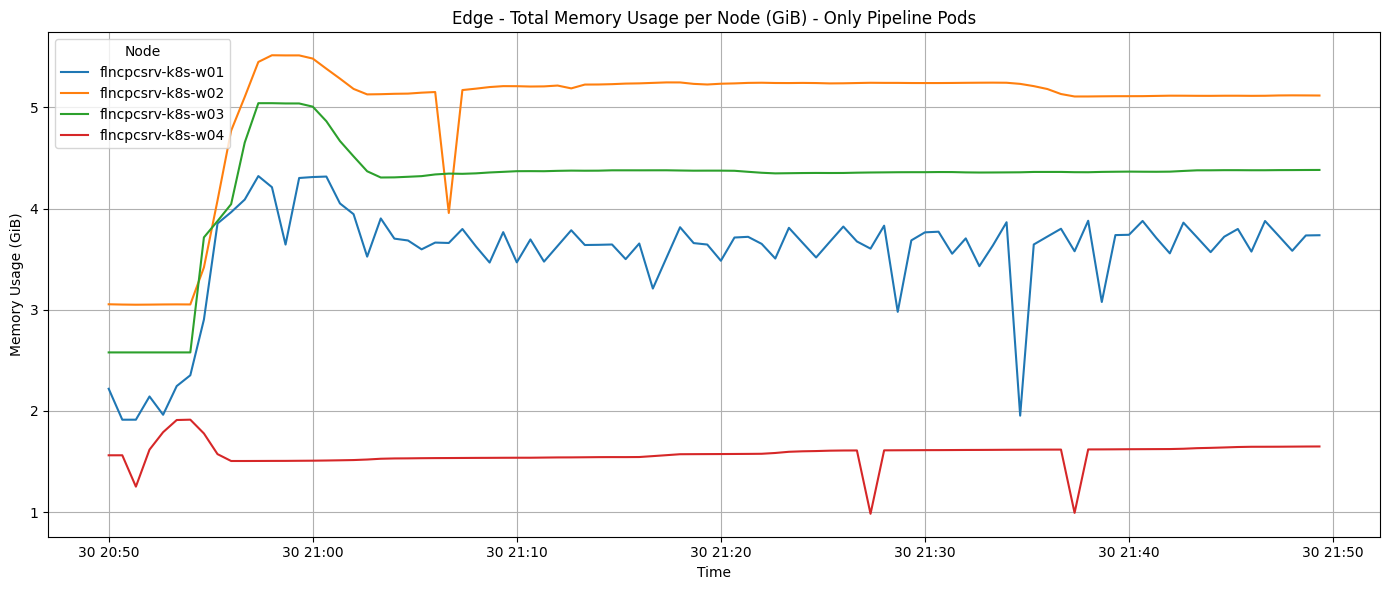

In [13]:
memory_chart_nodes(df_container_memory_usage_bytes_filtered, "Edge - Total Memory Usage per Node (GiB) - Only Pipeline Pods")

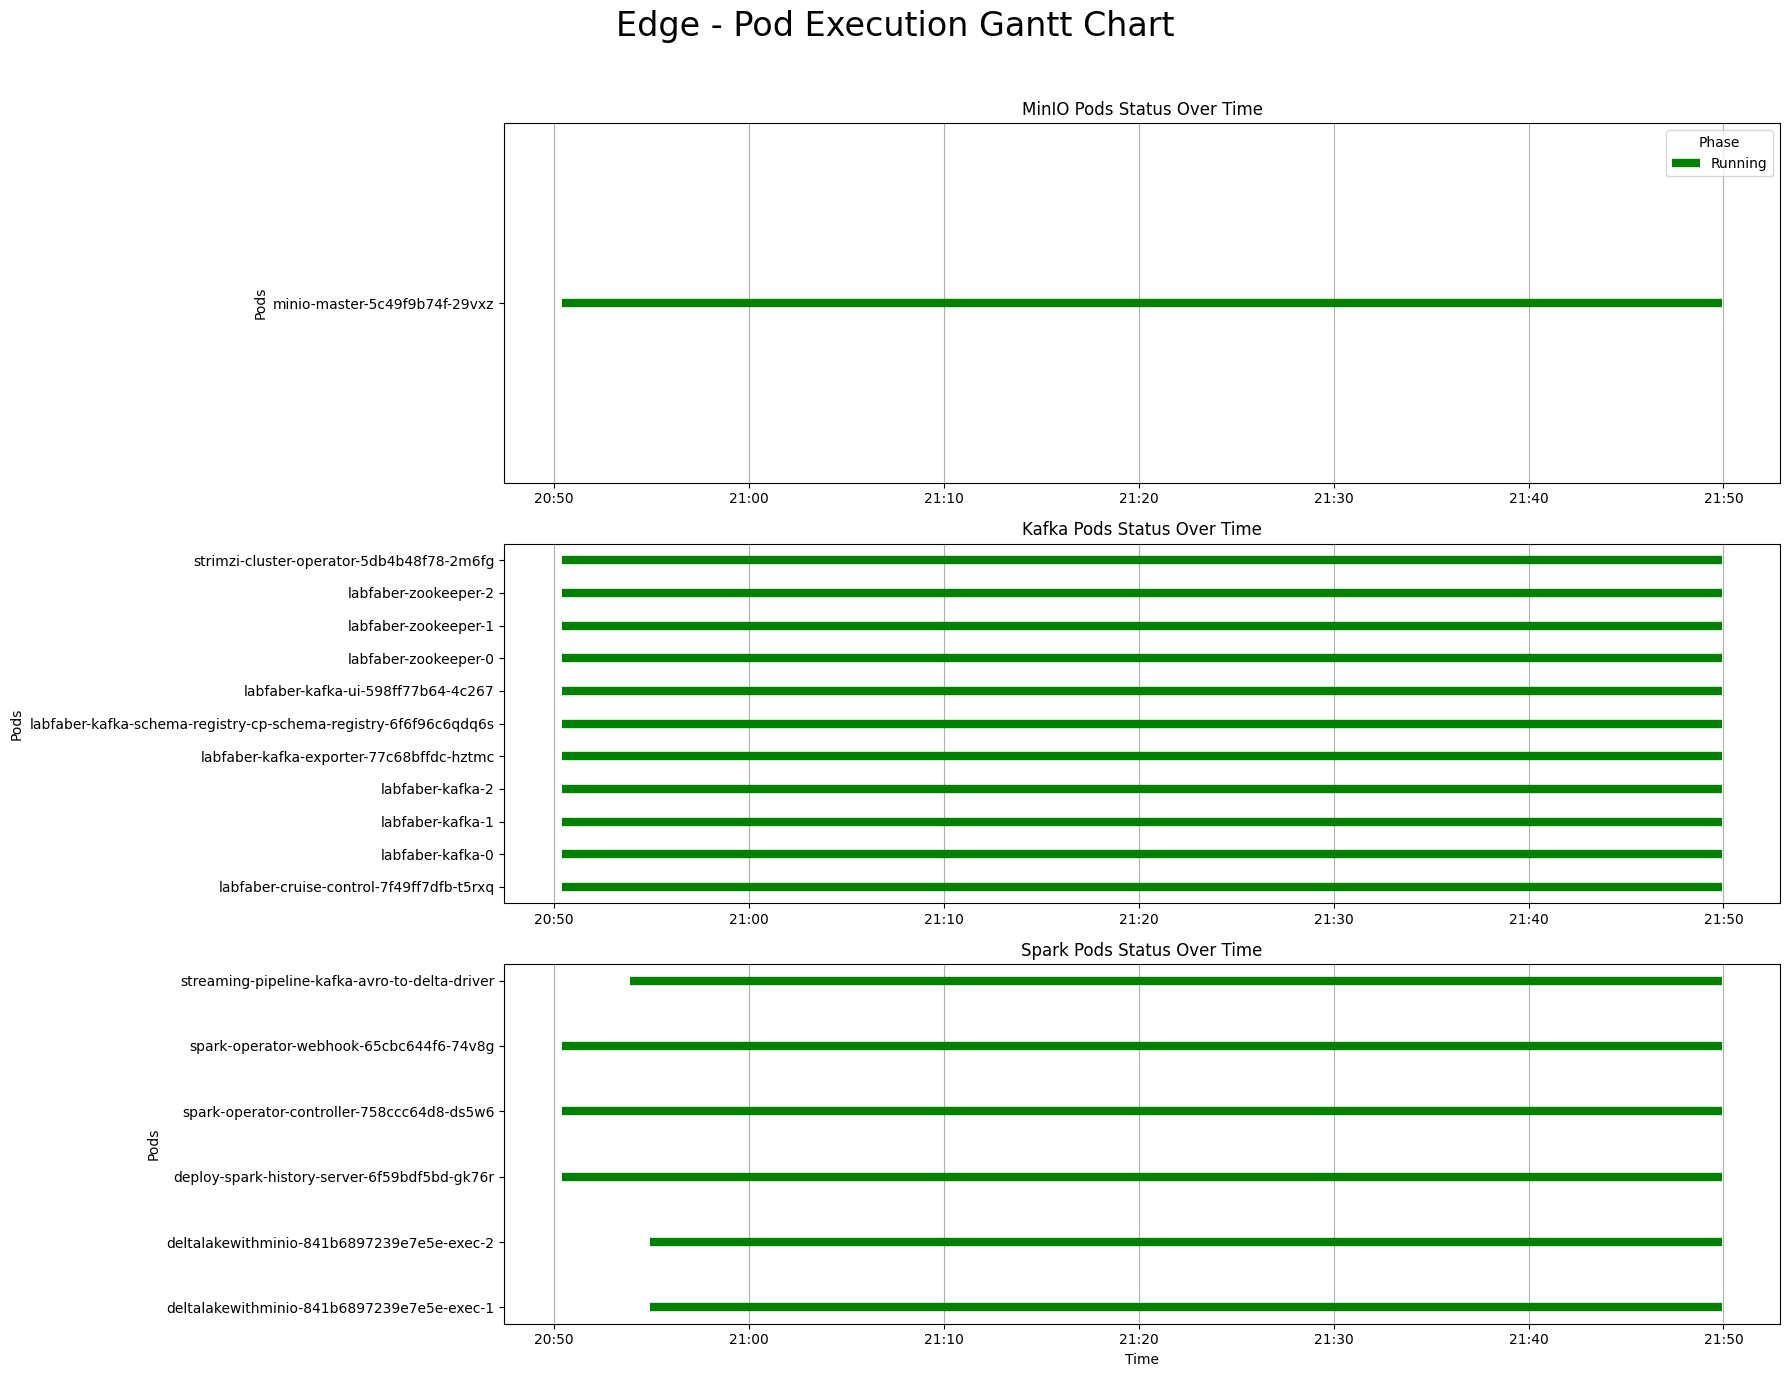

In [14]:
gantt_chart(df_kube_pod_status_phase, title="Edge - Pod Execution Gantt Chart")

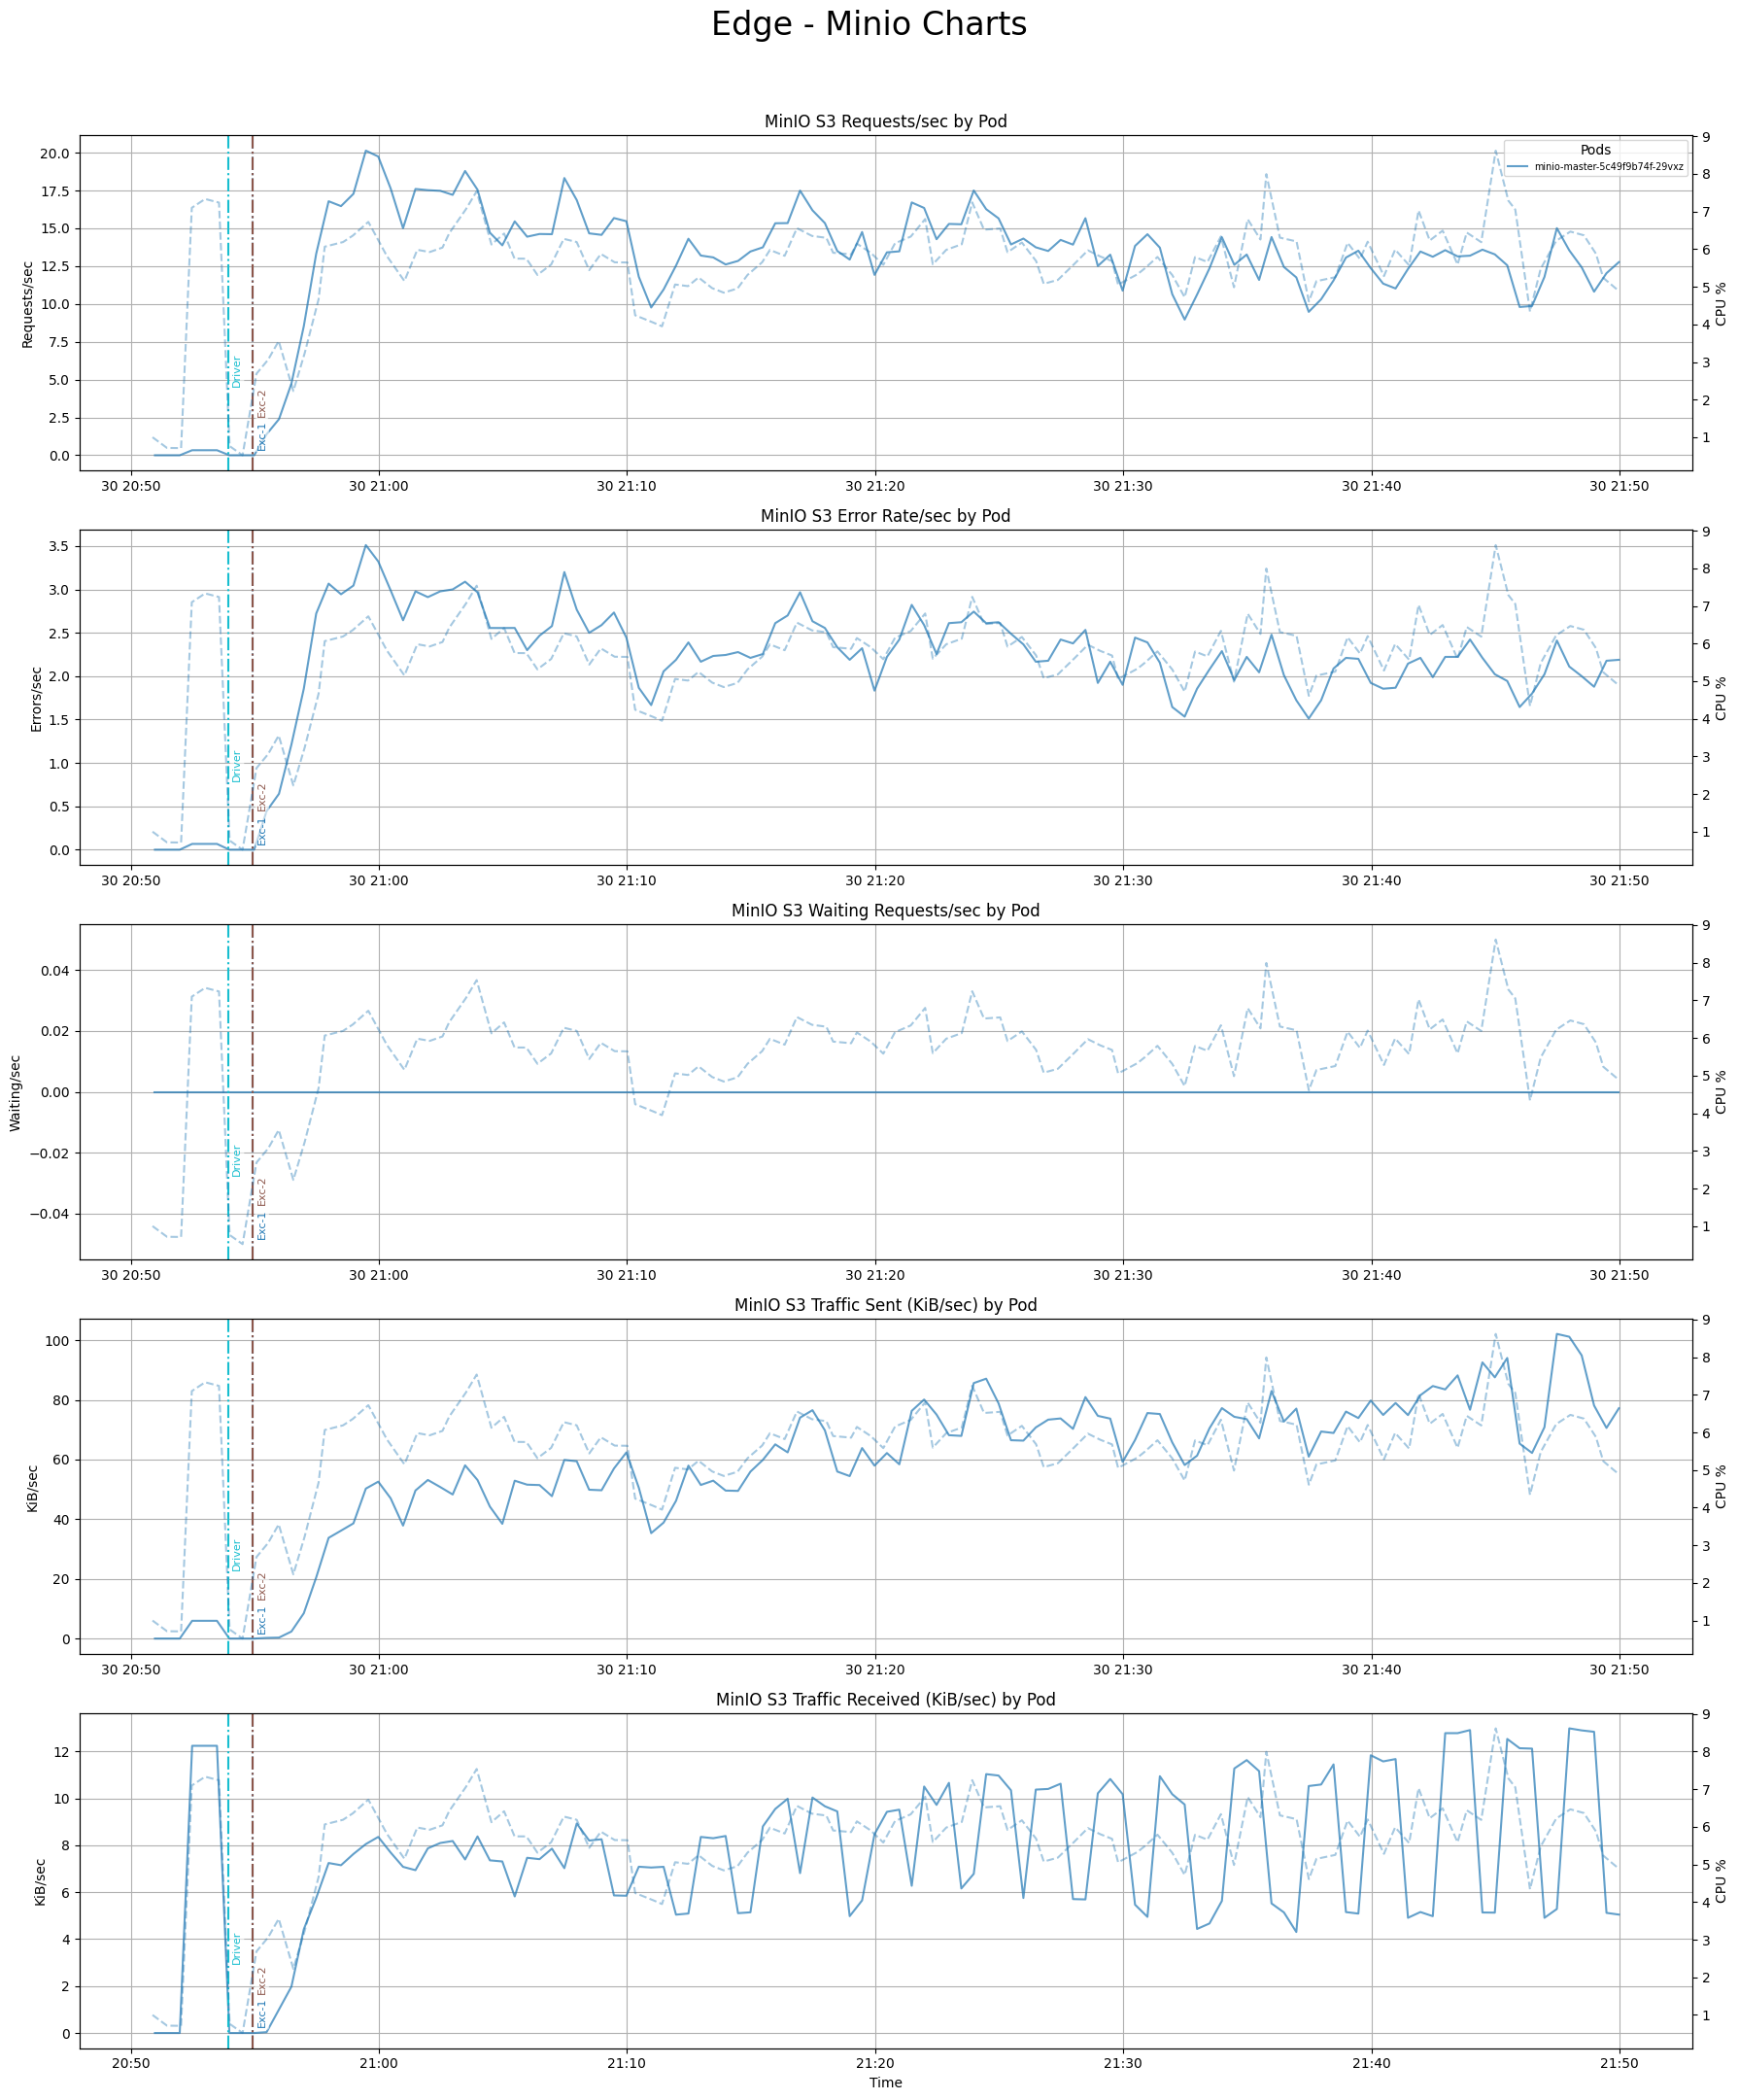

In [15]:
minio_charts(df_minio_total=df_minio_total, df_minio_errors=df_minio_errors, df_minio_waiting=df_minio_waiting, df_minio_sent_bytes=df_minio_sent_bytes, df_minio_received_bytes=df_minio_received_bytes, df_cpu=df_container_cpu_usage_seconds_total, df_status=df_kube_pod_status_phase, title="Edge - Minio Charts")

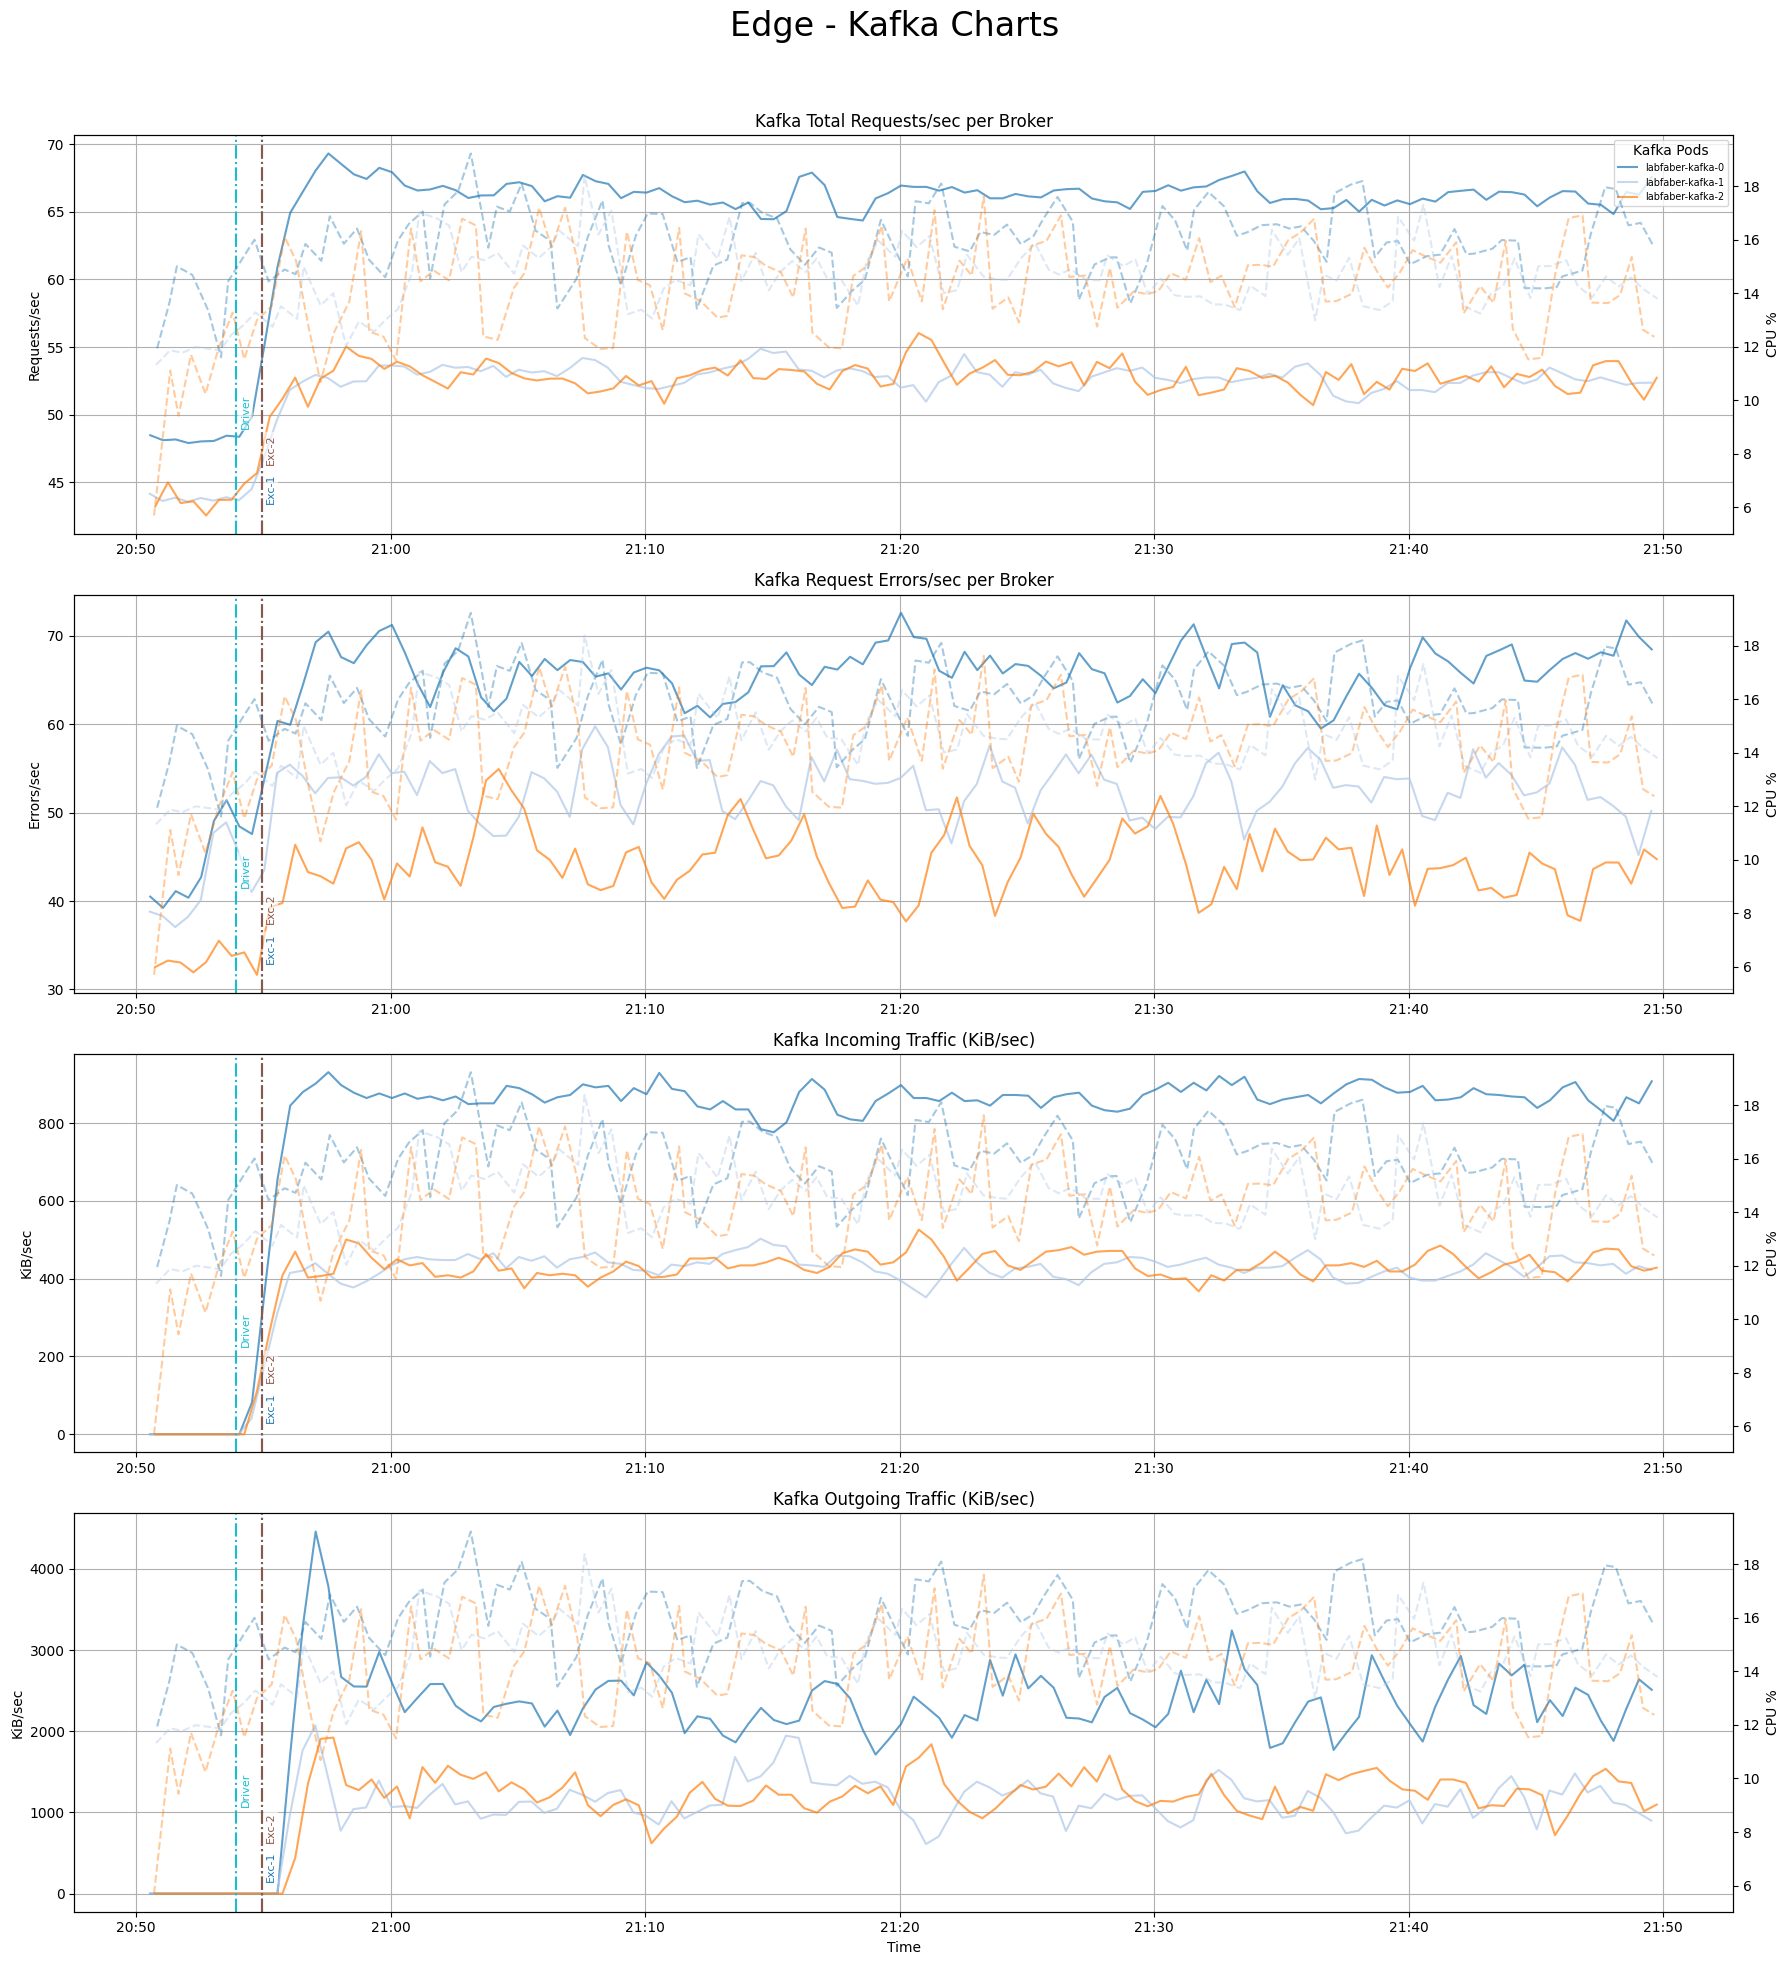

In [16]:
kafka_charts(kafka_bytes_in, kafka_bytes_out, kafka_requests, kafka_requests_errors, kafka_messages_in, df_container_cpu_usage_seconds_total, df_kube_pod_status_phase, title="Edge - Kafka Charts")

---

# Cloud Data

In [17]:
base_path = f"../../data/raw/{experiment_name}/{experiment_name}_cloud"

NODE_CPU_LIMITS = {
    'worker-pool-tauaf': 400,
    'worker-pool-tauaq': 400,
    'worker-pool-tauax': 400,
    'worker-pool-tauay': 400
}

memory = 8.192 * 2 # 16 GB

NODE_MEMORY_LIMITS = {
    'worker-pool-tauaf': memory,
    'worker-pool-tauaq': memory,
    'worker-pool-tauax': memory,
    'worker-pool-tauay': memory
}

df_container_cpu_usage_seconds_total = pd.read_parquet(base_path + "/container_cpu_usage_seconds_total.parquet")
df_container_memory_usage_bytes = pd.read_parquet(base_path + "/container_memory_usage_bytes.parquet")
df_kube_pod_status_phase = pd.read_parquet(base_path + "/kube_pod_status_phase.parquet")

kafka_bytes_in = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_bytesin_total.parquet")
kafka_bytes_out = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_bytesout_total.parquet")
kafka_messages_in = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_messagesin_total.parquet")
kafka_requests = pd.read_parquet(base_path + "/kafka_network_requestmetrics_requests_total.parquet")
kafka_requests_errors = pd.read_parquet(base_path + "/kafka_network_requestmetrics_errors_total.parquet")

# === Load all MinIO metric CSVs ===
df_minio_incoming = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_incoming_total.parquet').reset_index(), start_time, end_time)
df_minio_total = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_total.parquet').reset_index(), start_time, end_time)
df_minio_waiting = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_waiting_total.parquet').reset_index(), start_time, end_time)
df_minio_errors = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_errors_total.parquet').reset_index(), start_time, end_time)
df_minio_sent_bytes = time_filter(pd.read_parquet(base_path + '/minio_s3_traffic_sent_bytes.parquet').reset_index(), start_time, end_time)
df_minio_received_bytes = time_filter(pd.read_parquet(base_path + '/minio_s3_traffic_received_bytes.parquet').reset_index(), start_time, end_time)

df_container_cpu_usage_seconds_total = df_container_cpu_usage_seconds_total.reset_index()
df_container_memory_usage_bytes = df_container_memory_usage_bytes.reset_index()
df_kube_pod_status_phase = df_kube_pod_status_phase.reset_index()

kafka_bytes_in = kafka_bytes_in.reset_index()
kafka_bytes_out = kafka_bytes_out.reset_index()
kafka_messages_in = kafka_messages_in.reset_index()
kafka_requests = kafka_requests.reset_index()
kafka_requests_errors = kafka_requests_errors.reset_index()

df_container_cpu_usage_seconds_total = time_filter(df_container_cpu_usage_seconds_total, start_time, end_time)
df_container_memory_usage_bytes = time_filter(df_container_memory_usage_bytes, start_time, end_time)
df_kube_pod_status_phase = time_filter(df_kube_pod_status_phase, start_time, end_time)

kafka_bytes_in = time_filter(kafka_bytes_in, start_time, end_time)
kafka_bytes_out = time_filter(kafka_bytes_out, start_time, end_time)
kafka_messages_in = time_filter(kafka_messages_in, start_time, end_time)
kafka_requests = time_filter(kafka_requests, start_time, end_time)
kafka_requests_errors = time_filter(kafka_requests_errors, start_time, end_time)

selected_pods = get_selected_pods(df_kube_pod_status_phase)

df_kube_pod_status_phase = df_kube_pod_status_phase[df_kube_pod_status_phase["pod"].isin(selected_pods)]
df_container_cpu_usage_seconds_total_filtered = df_container_cpu_usage_seconds_total[df_container_cpu_usage_seconds_total["pod"].isin(selected_pods)]
df_container_memory_usage_bytes_filtered = df_container_memory_usage_bytes[df_container_memory_usage_bytes["pod"].isin(selected_pods)]

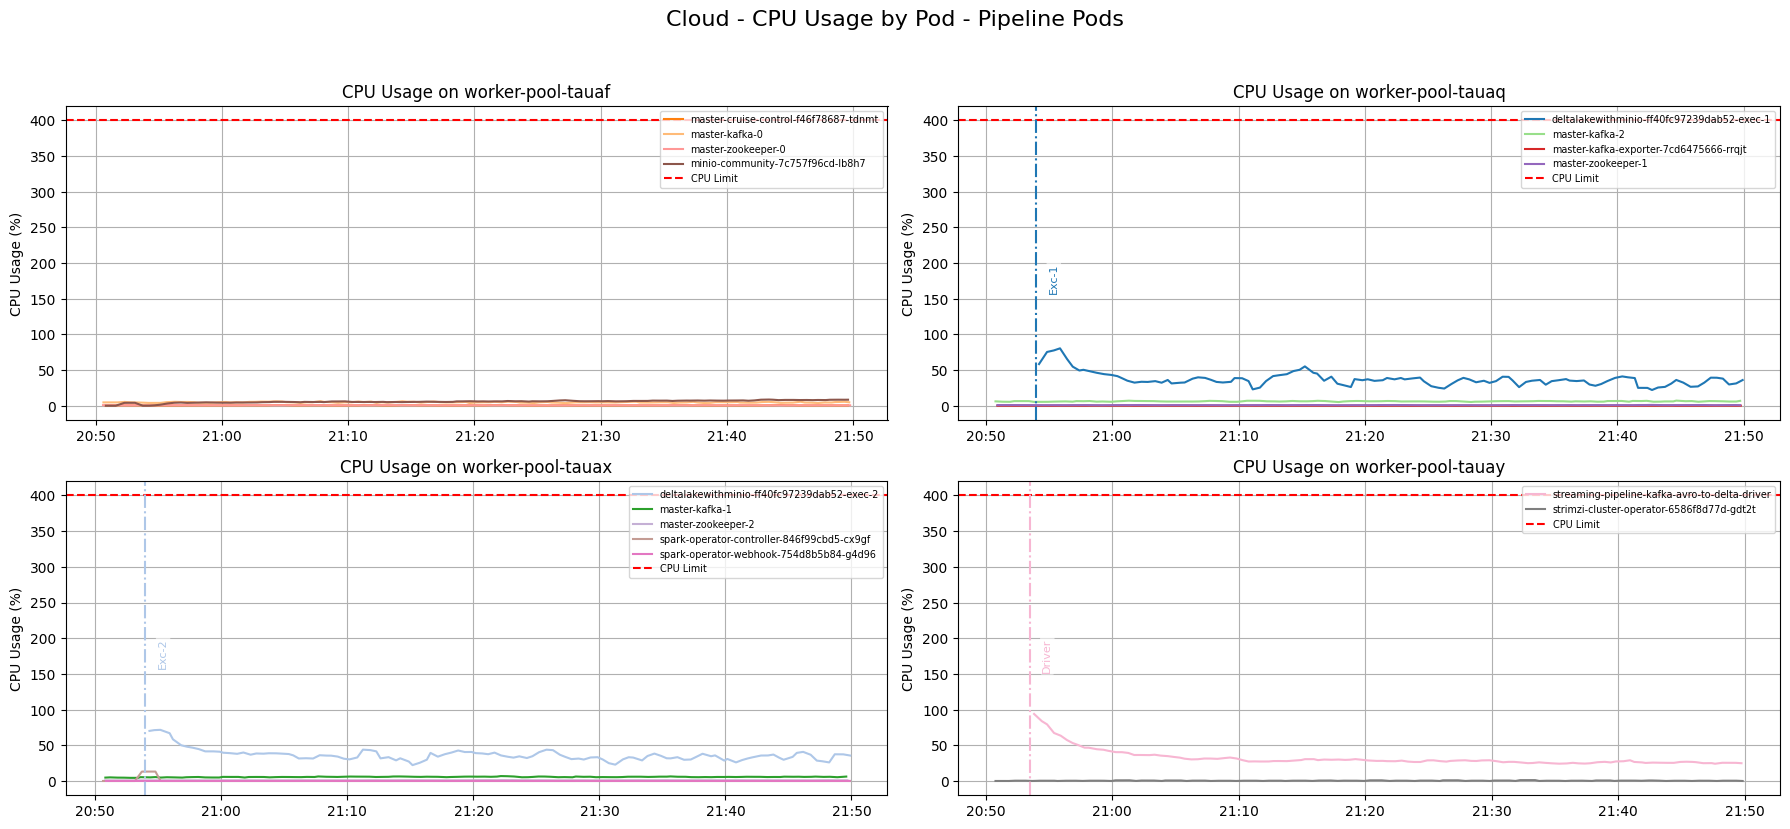

In [18]:
cpu_chart(df_container_cpu_usage_seconds_total_filtered, df_kube_pod_status_phase, title="Cloud - CPU Usage by Pod - Pipeline Pods", node_cpu_limits=NODE_CPU_LIMITS)

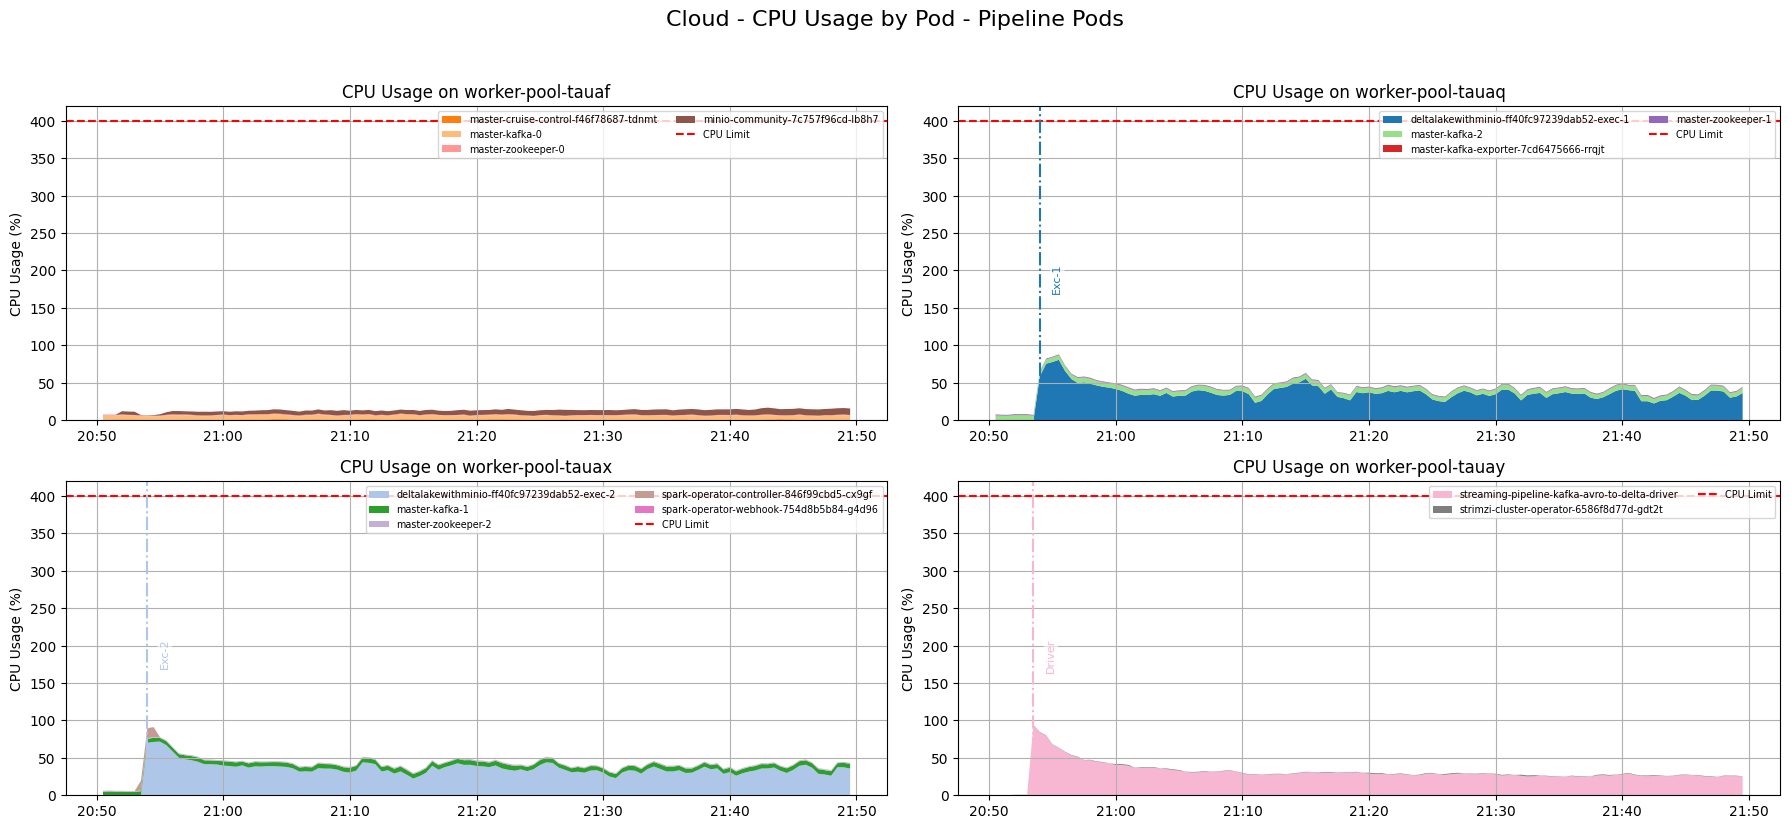

In [19]:
cpu_chart_stacked(df_container_cpu_usage_seconds_total_filtered, df_kube_pod_status_phase, title="Cloud - CPU Usage by Pod - Pipeline Pods", node_cpu_limits=NODE_CPU_LIMITS)

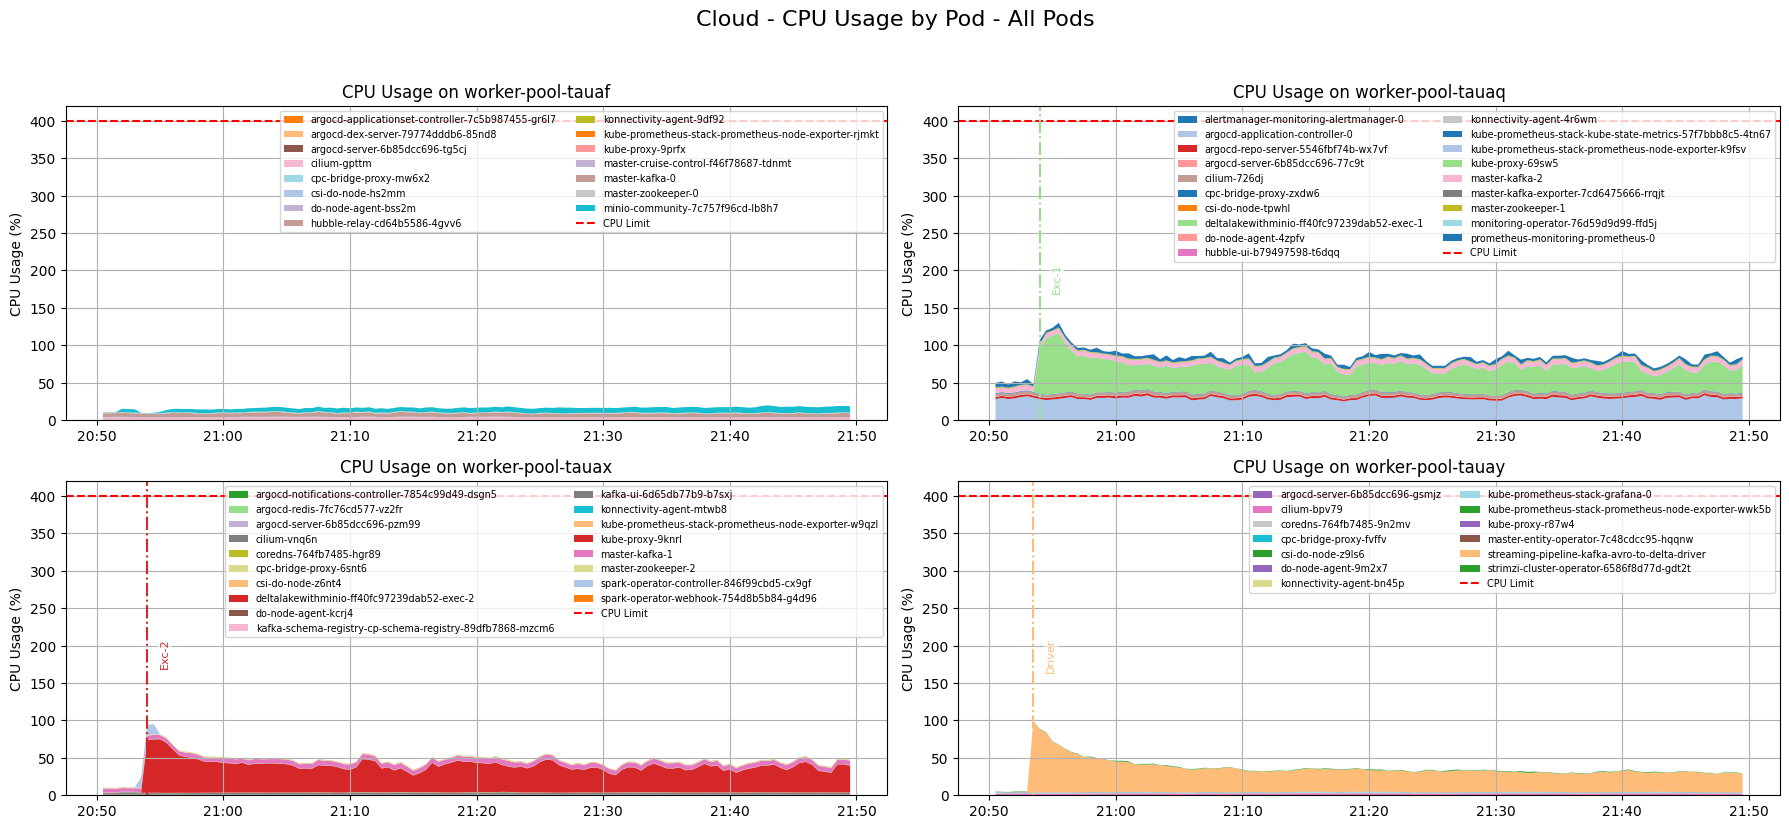

In [20]:
cpu_chart_stacked(df_container_cpu_usage_seconds_total, df_kube_pod_status_phase, title="Cloud - CPU Usage by Pod - All Pods", node_cpu_limits=NODE_CPU_LIMITS)

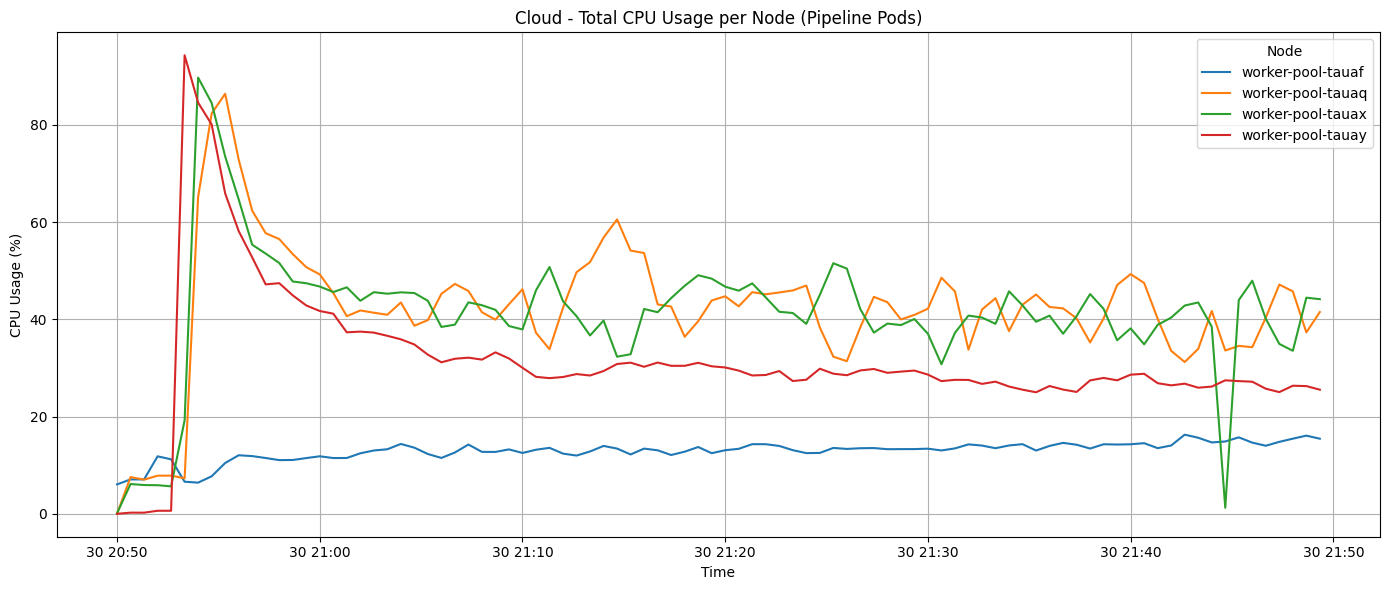

In [21]:
cpu_chart_nodes(df_container_cpu_usage_seconds_total_filtered, "Cloud - Total CPU Usage per Node (Pipeline Pods)")

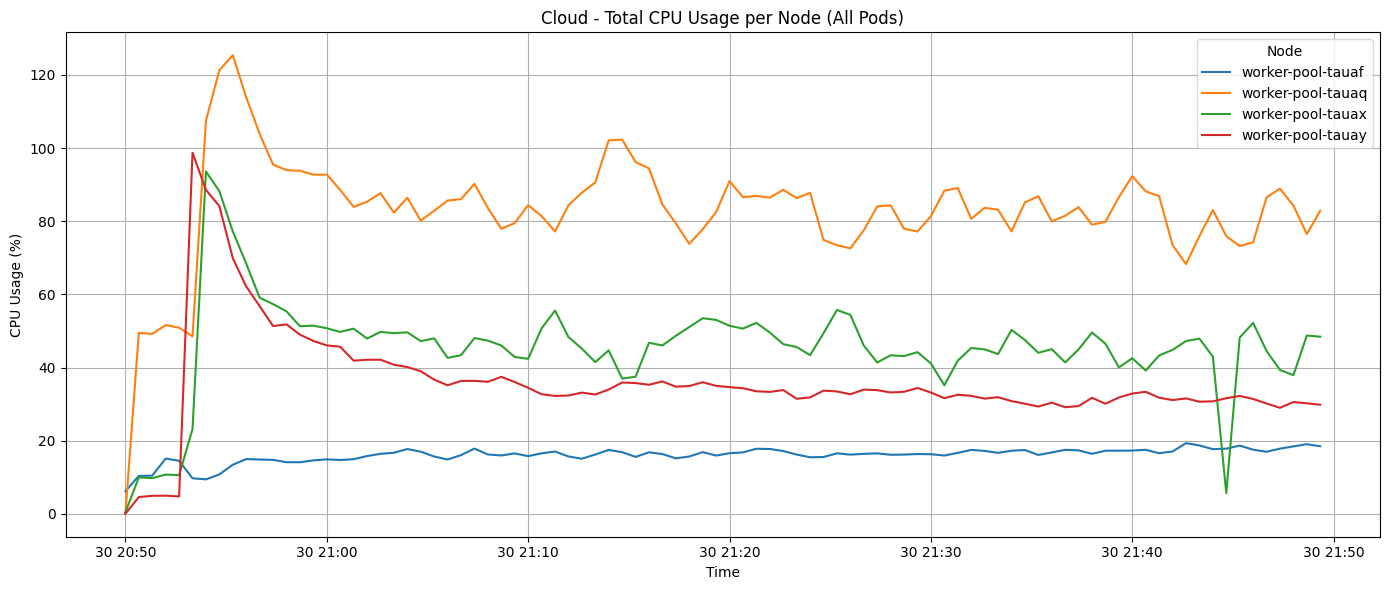

In [22]:
cpu_chart_nodes(df_container_cpu_usage_seconds_total, "Cloud - Total CPU Usage per Node (All Pods)")

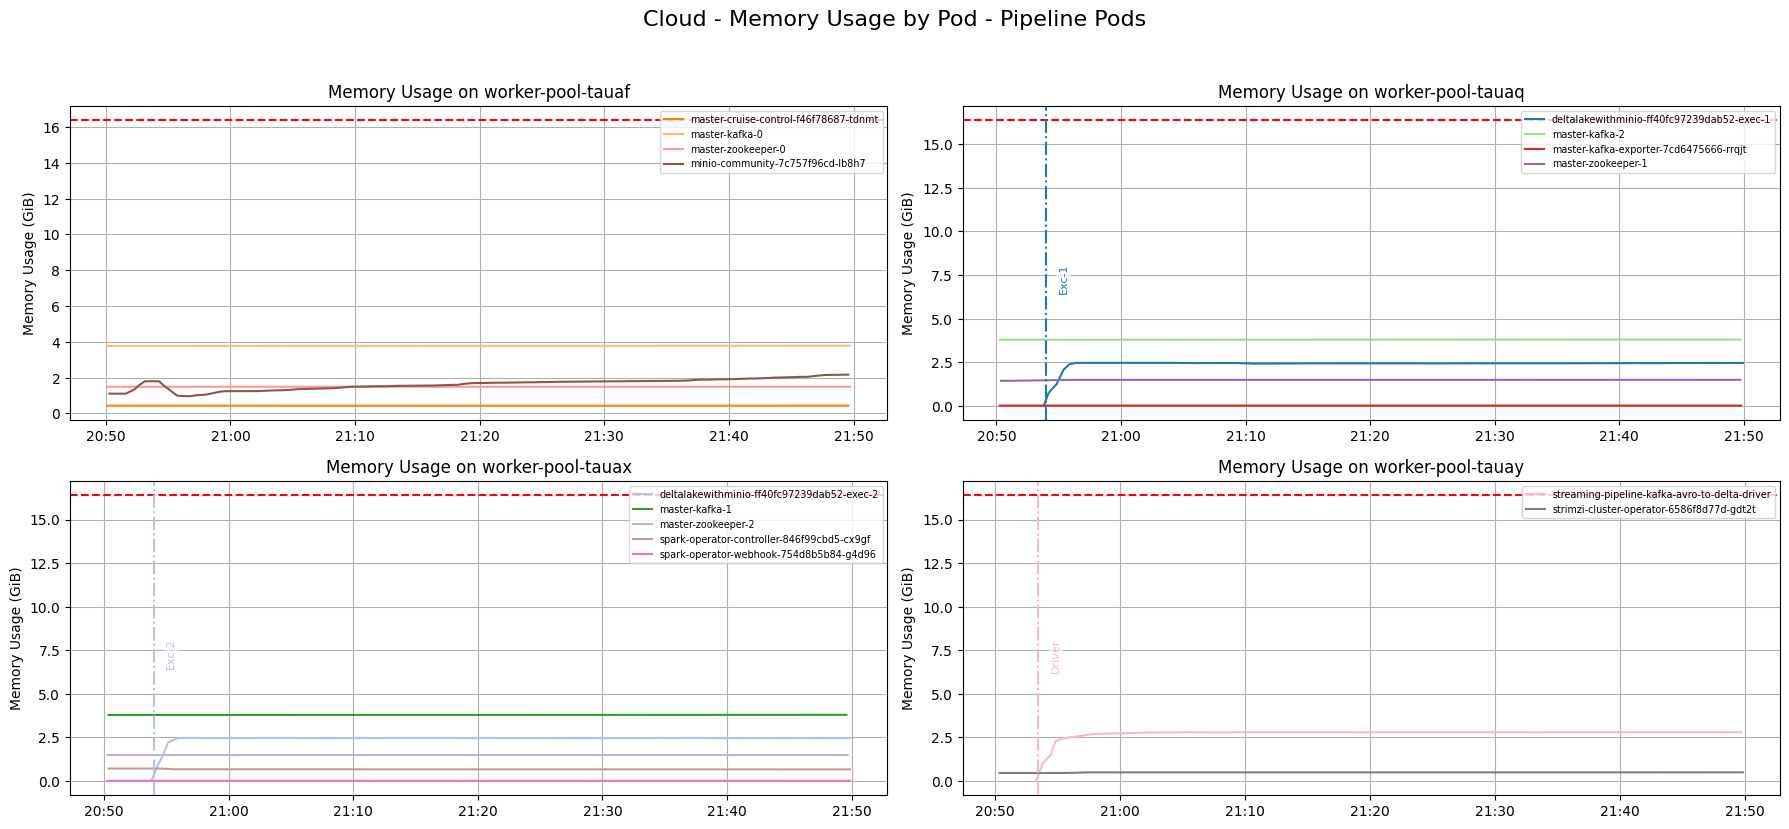

In [23]:
memory_chart(df_container_memory_usage_bytes_filtered, df_kube_pod_status_phase, title="Cloud - Memory Usage by Pod - Pipeline Pods", node_memory_limits=NODE_MEMORY_LIMITS)

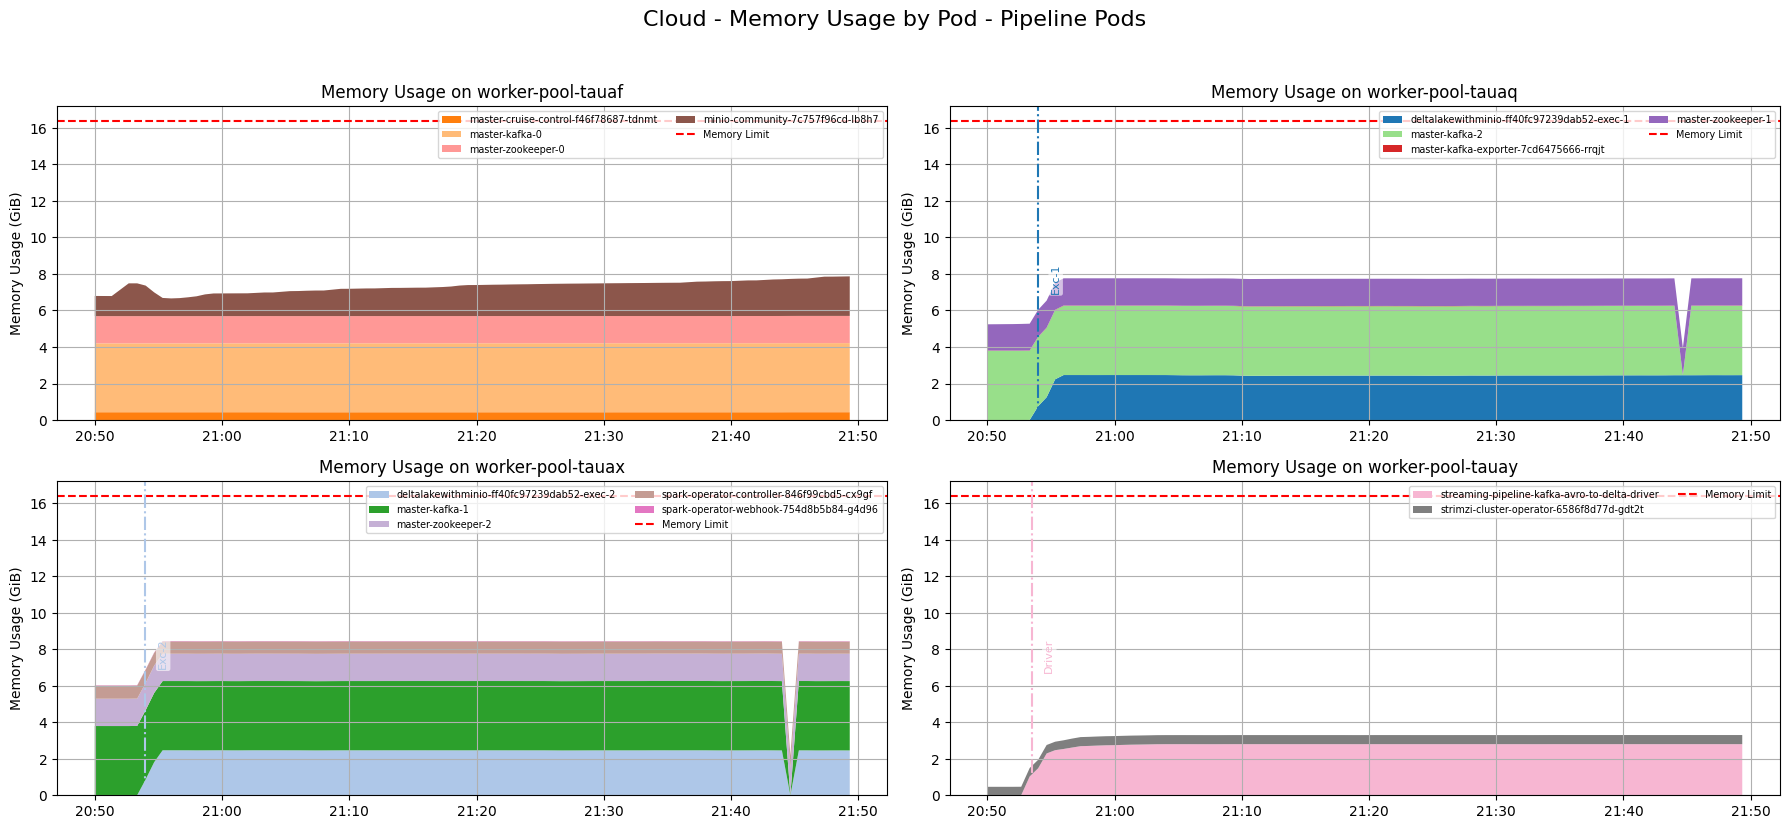

In [24]:
memory_chart_stacked(df_container_memory_usage_bytes_filtered, df_kube_pod_status_phase, title="Cloud - Memory Usage by Pod - Pipeline Pods", node_memory_limits=NODE_MEMORY_LIMITS)

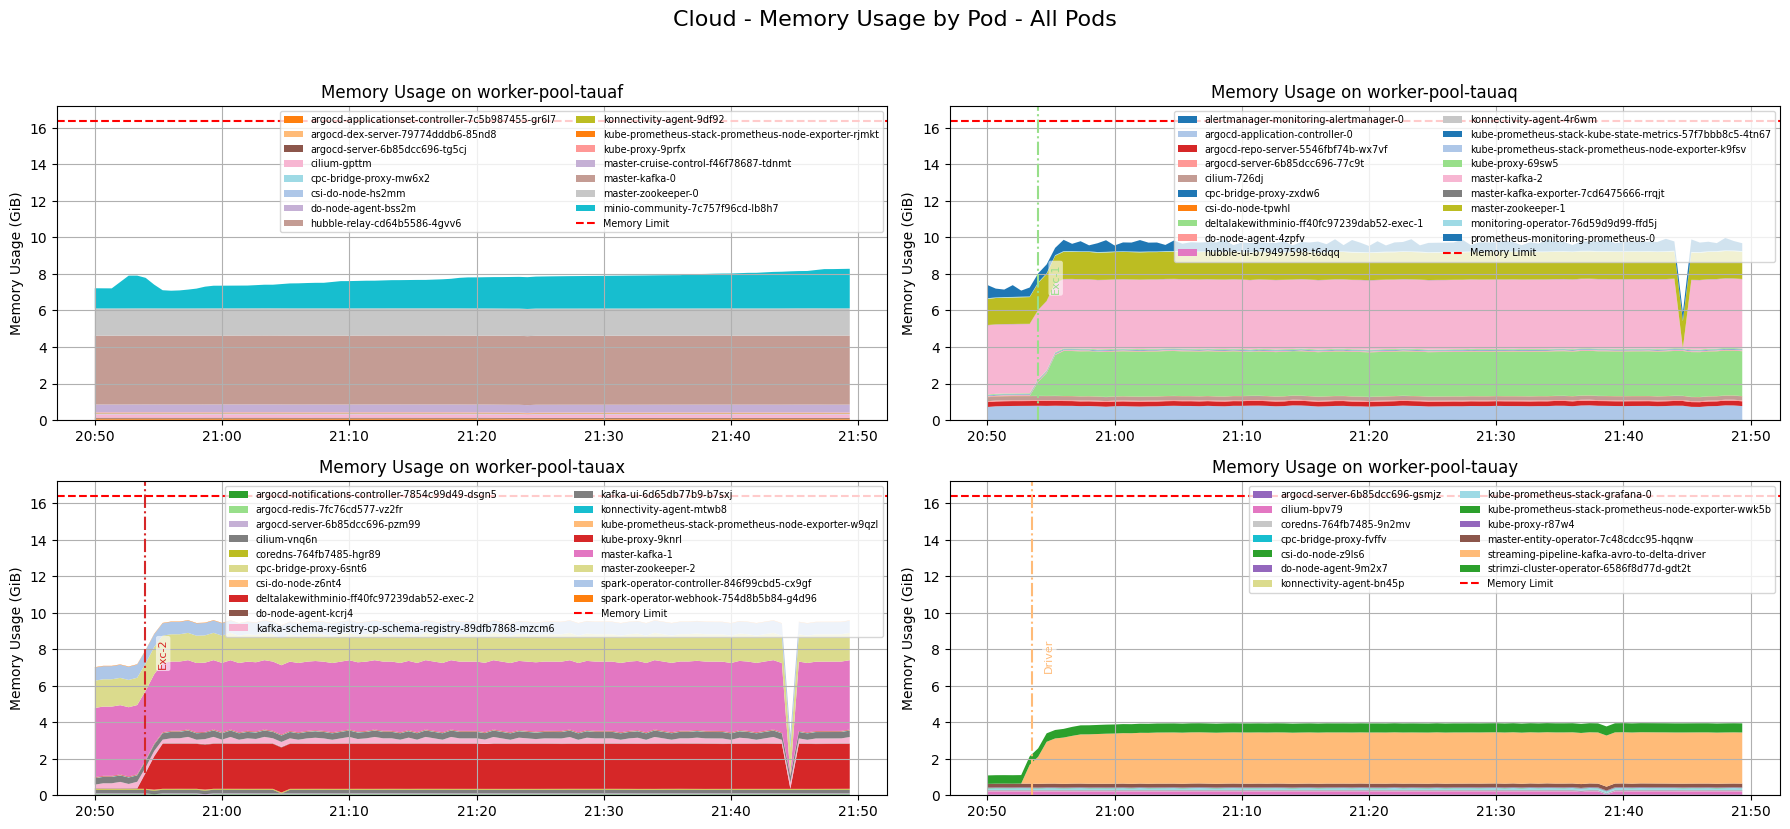

In [25]:
memory_chart_stacked(df_container_memory_usage_bytes, df_kube_pod_status_phase, title="Cloud - Memory Usage by Pod - All Pods", node_memory_limits=NODE_MEMORY_LIMITS )

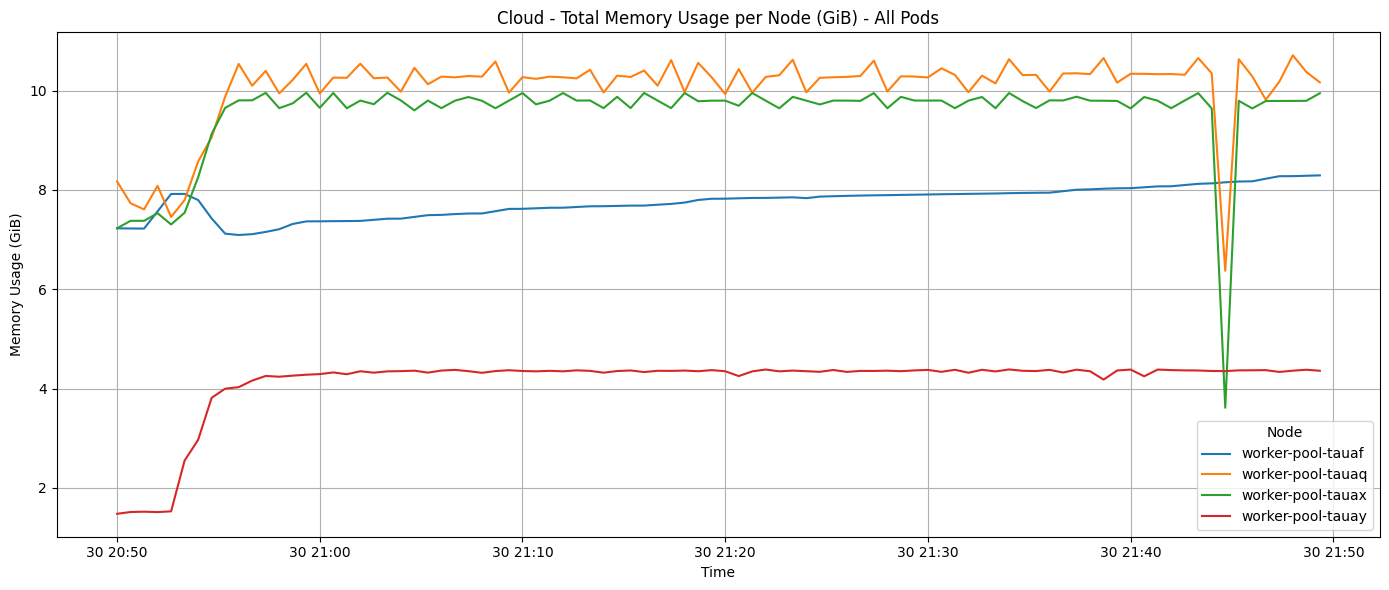

In [26]:
memory_chart_nodes(df_container_memory_usage_bytes, "Cloud - Total Memory Usage per Node (GiB) - All Pods")

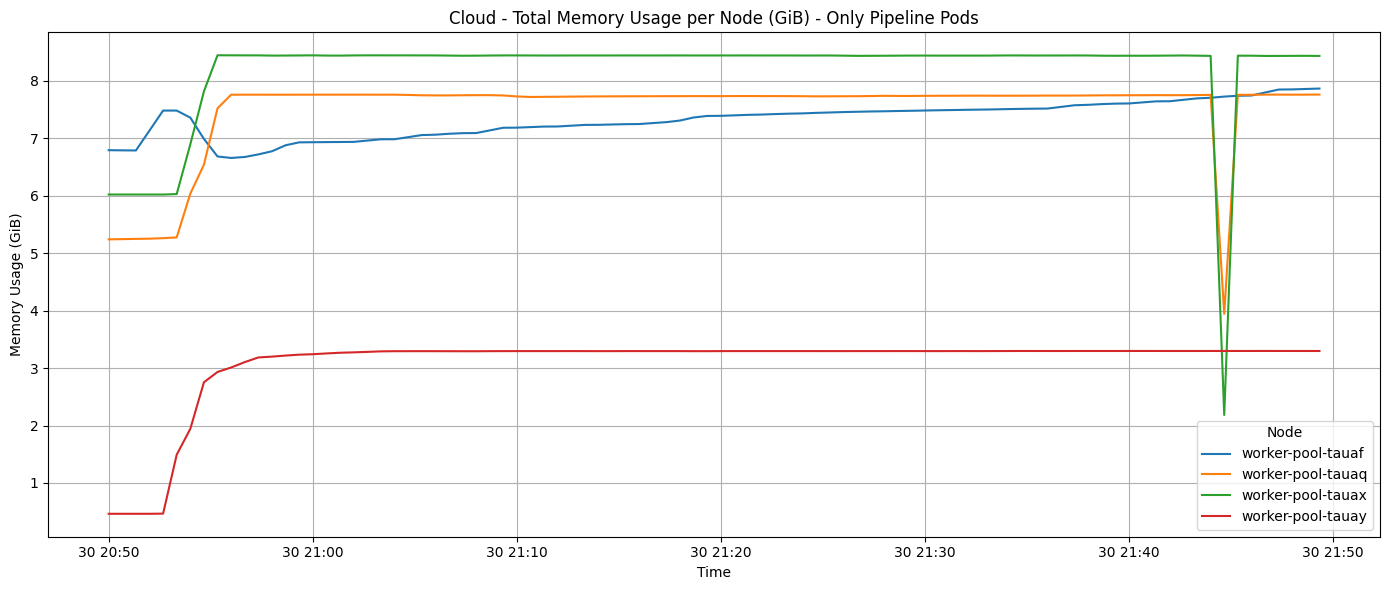

In [27]:
memory_chart_nodes(df_container_memory_usage_bytes_filtered, "Cloud - Total Memory Usage per Node (GiB) - Only Pipeline Pods")

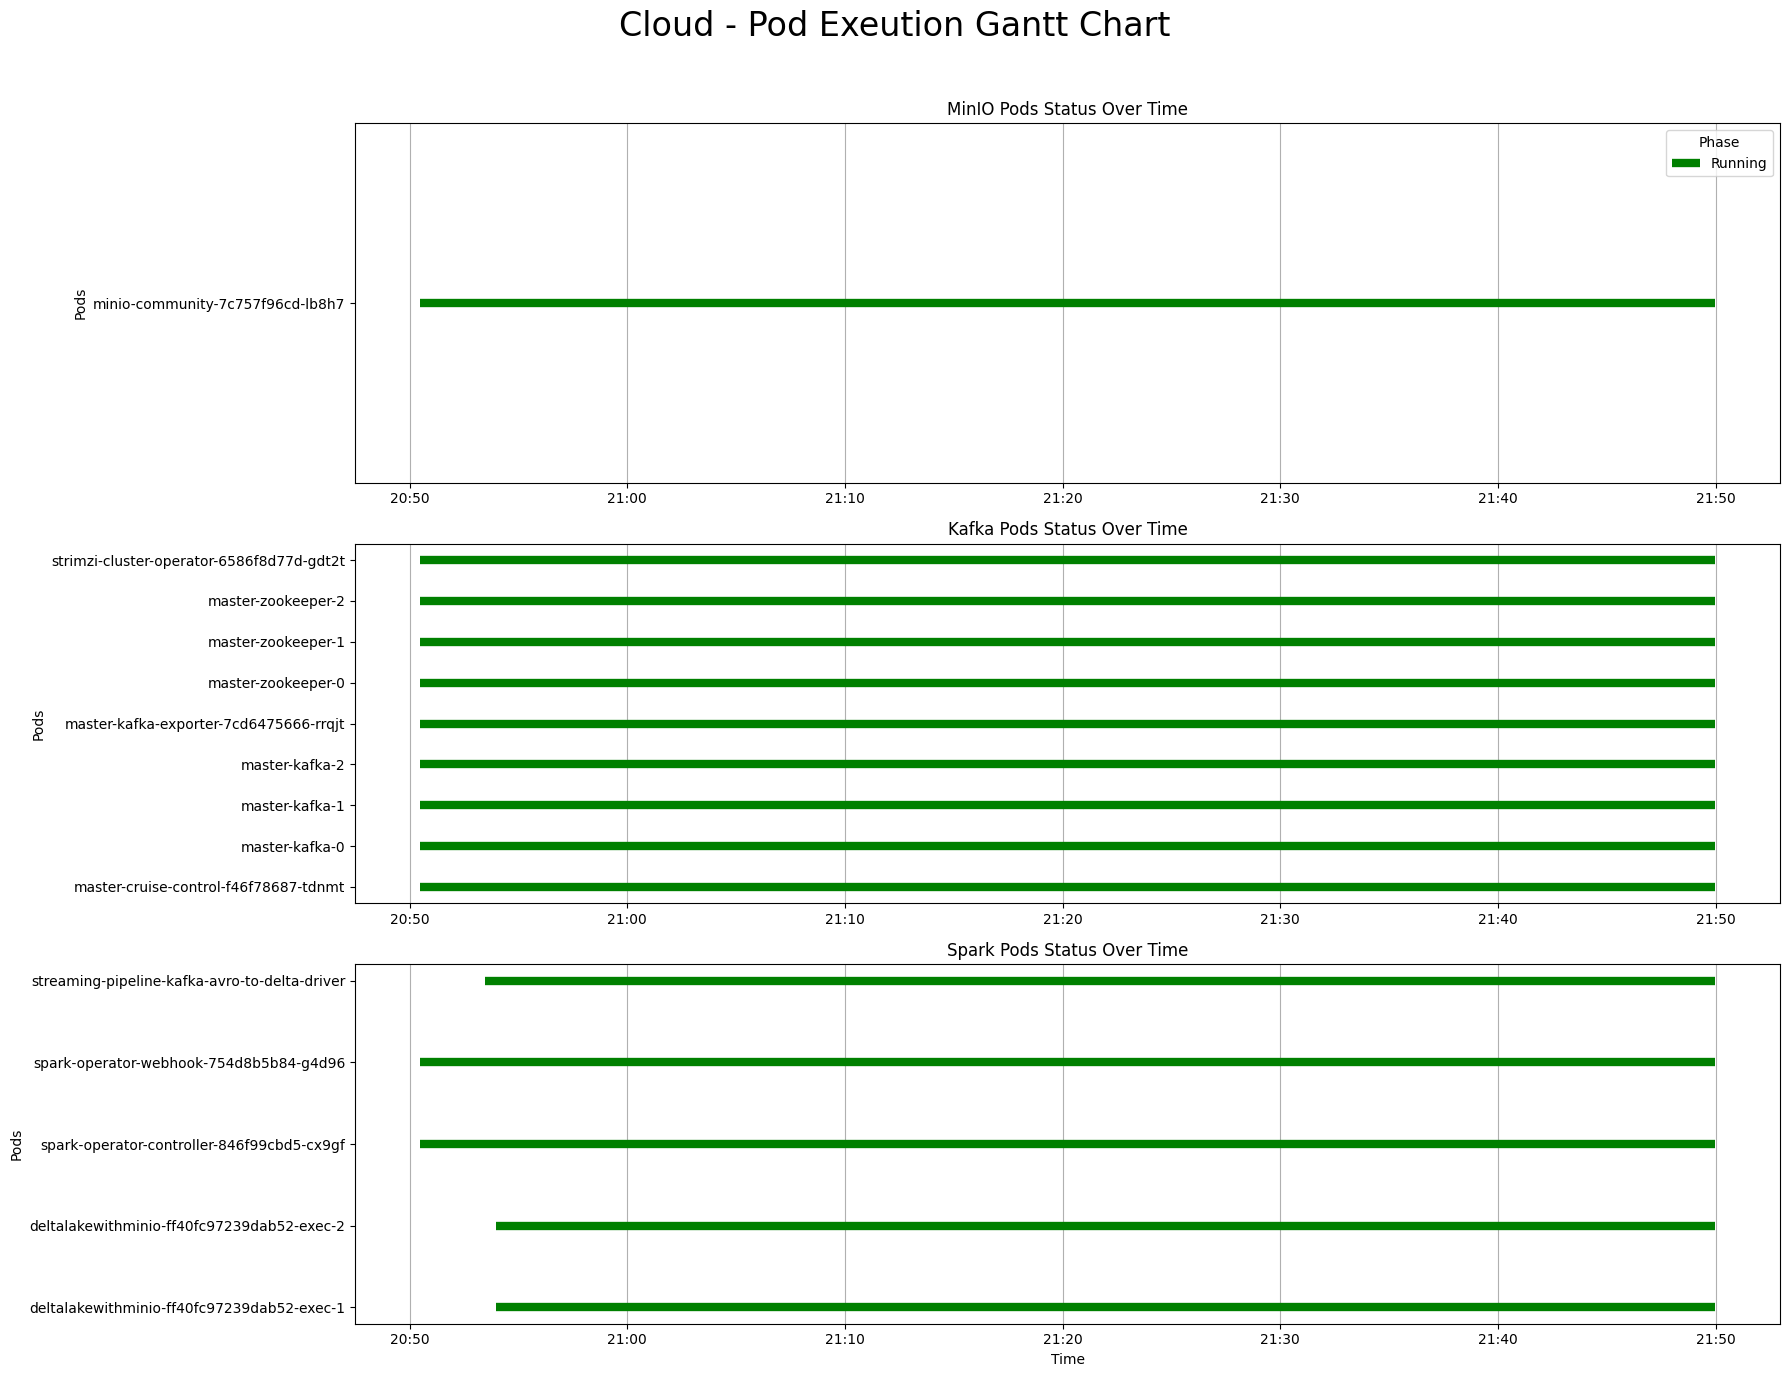

In [28]:
gantt_chart(df_kube_pod_status_phase, title="Cloud - Pod Exeution Gantt Chart")

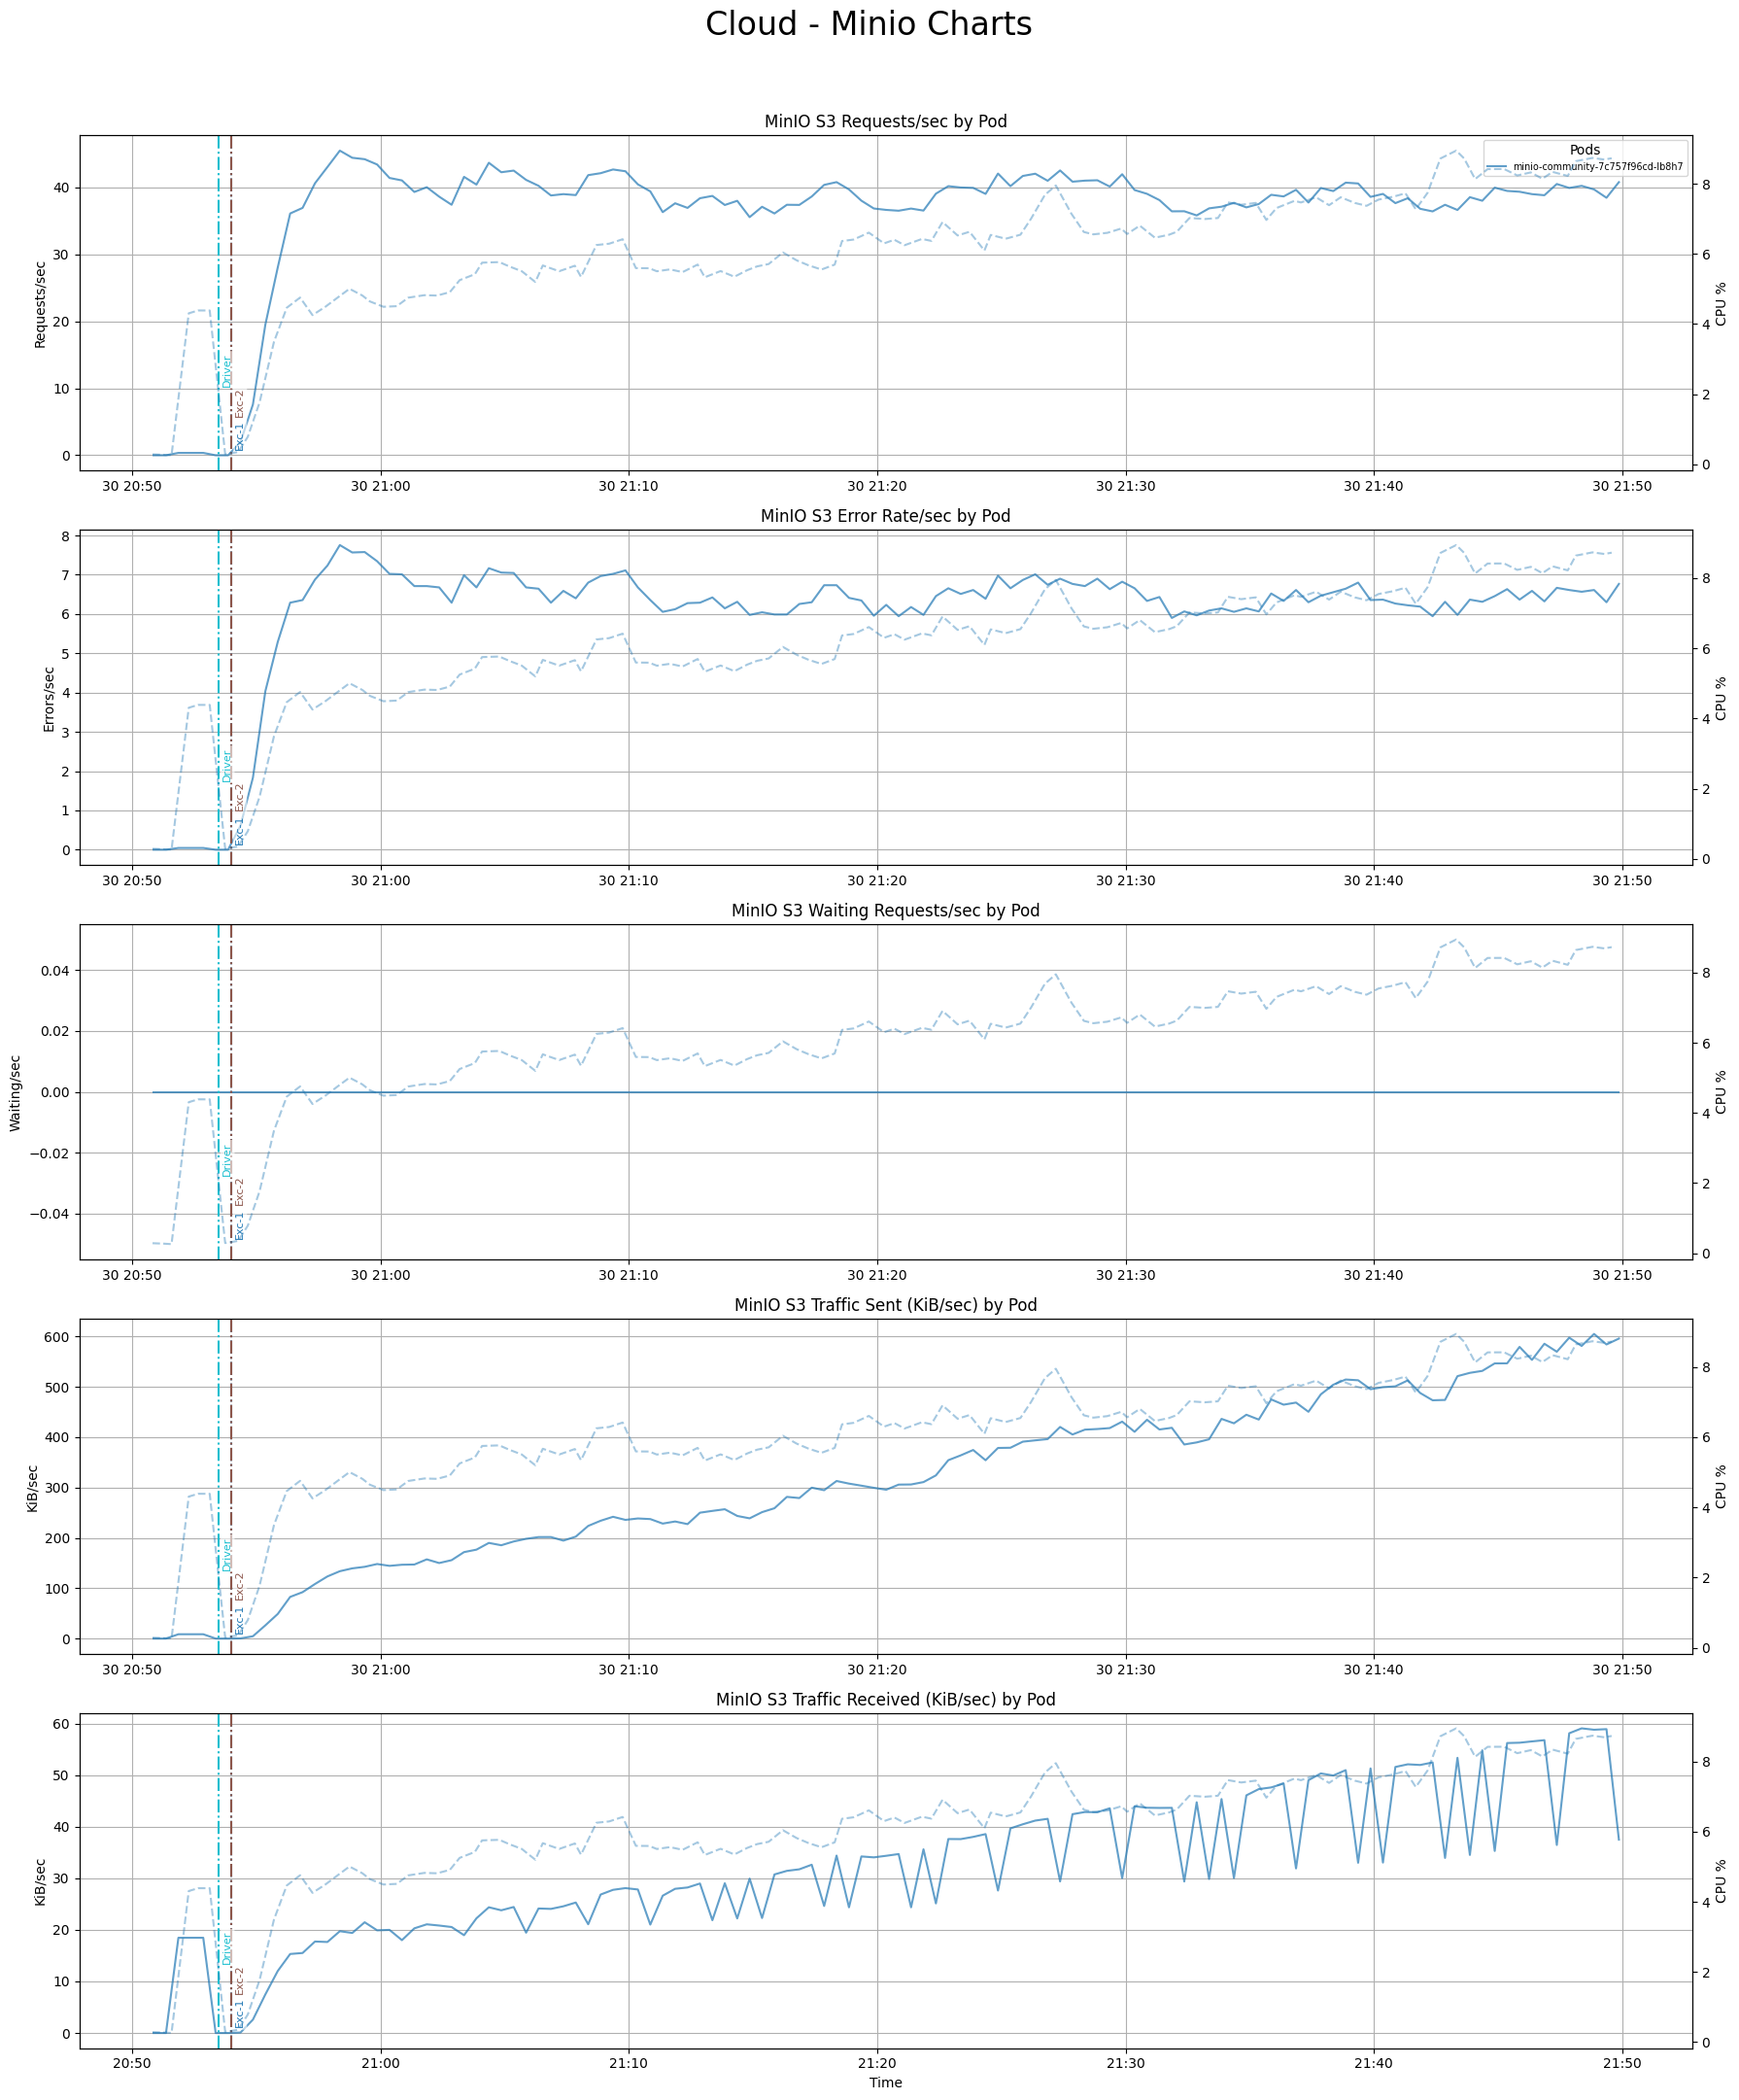

In [29]:
minio_charts(df_minio_total=df_minio_total, df_minio_errors=df_minio_errors, df_minio_waiting=df_minio_waiting, df_minio_sent_bytes=df_minio_sent_bytes, df_minio_received_bytes=df_minio_received_bytes, df_cpu=df_container_cpu_usage_seconds_total, df_status=df_kube_pod_status_phase, title="Cloud - Minio Charts")

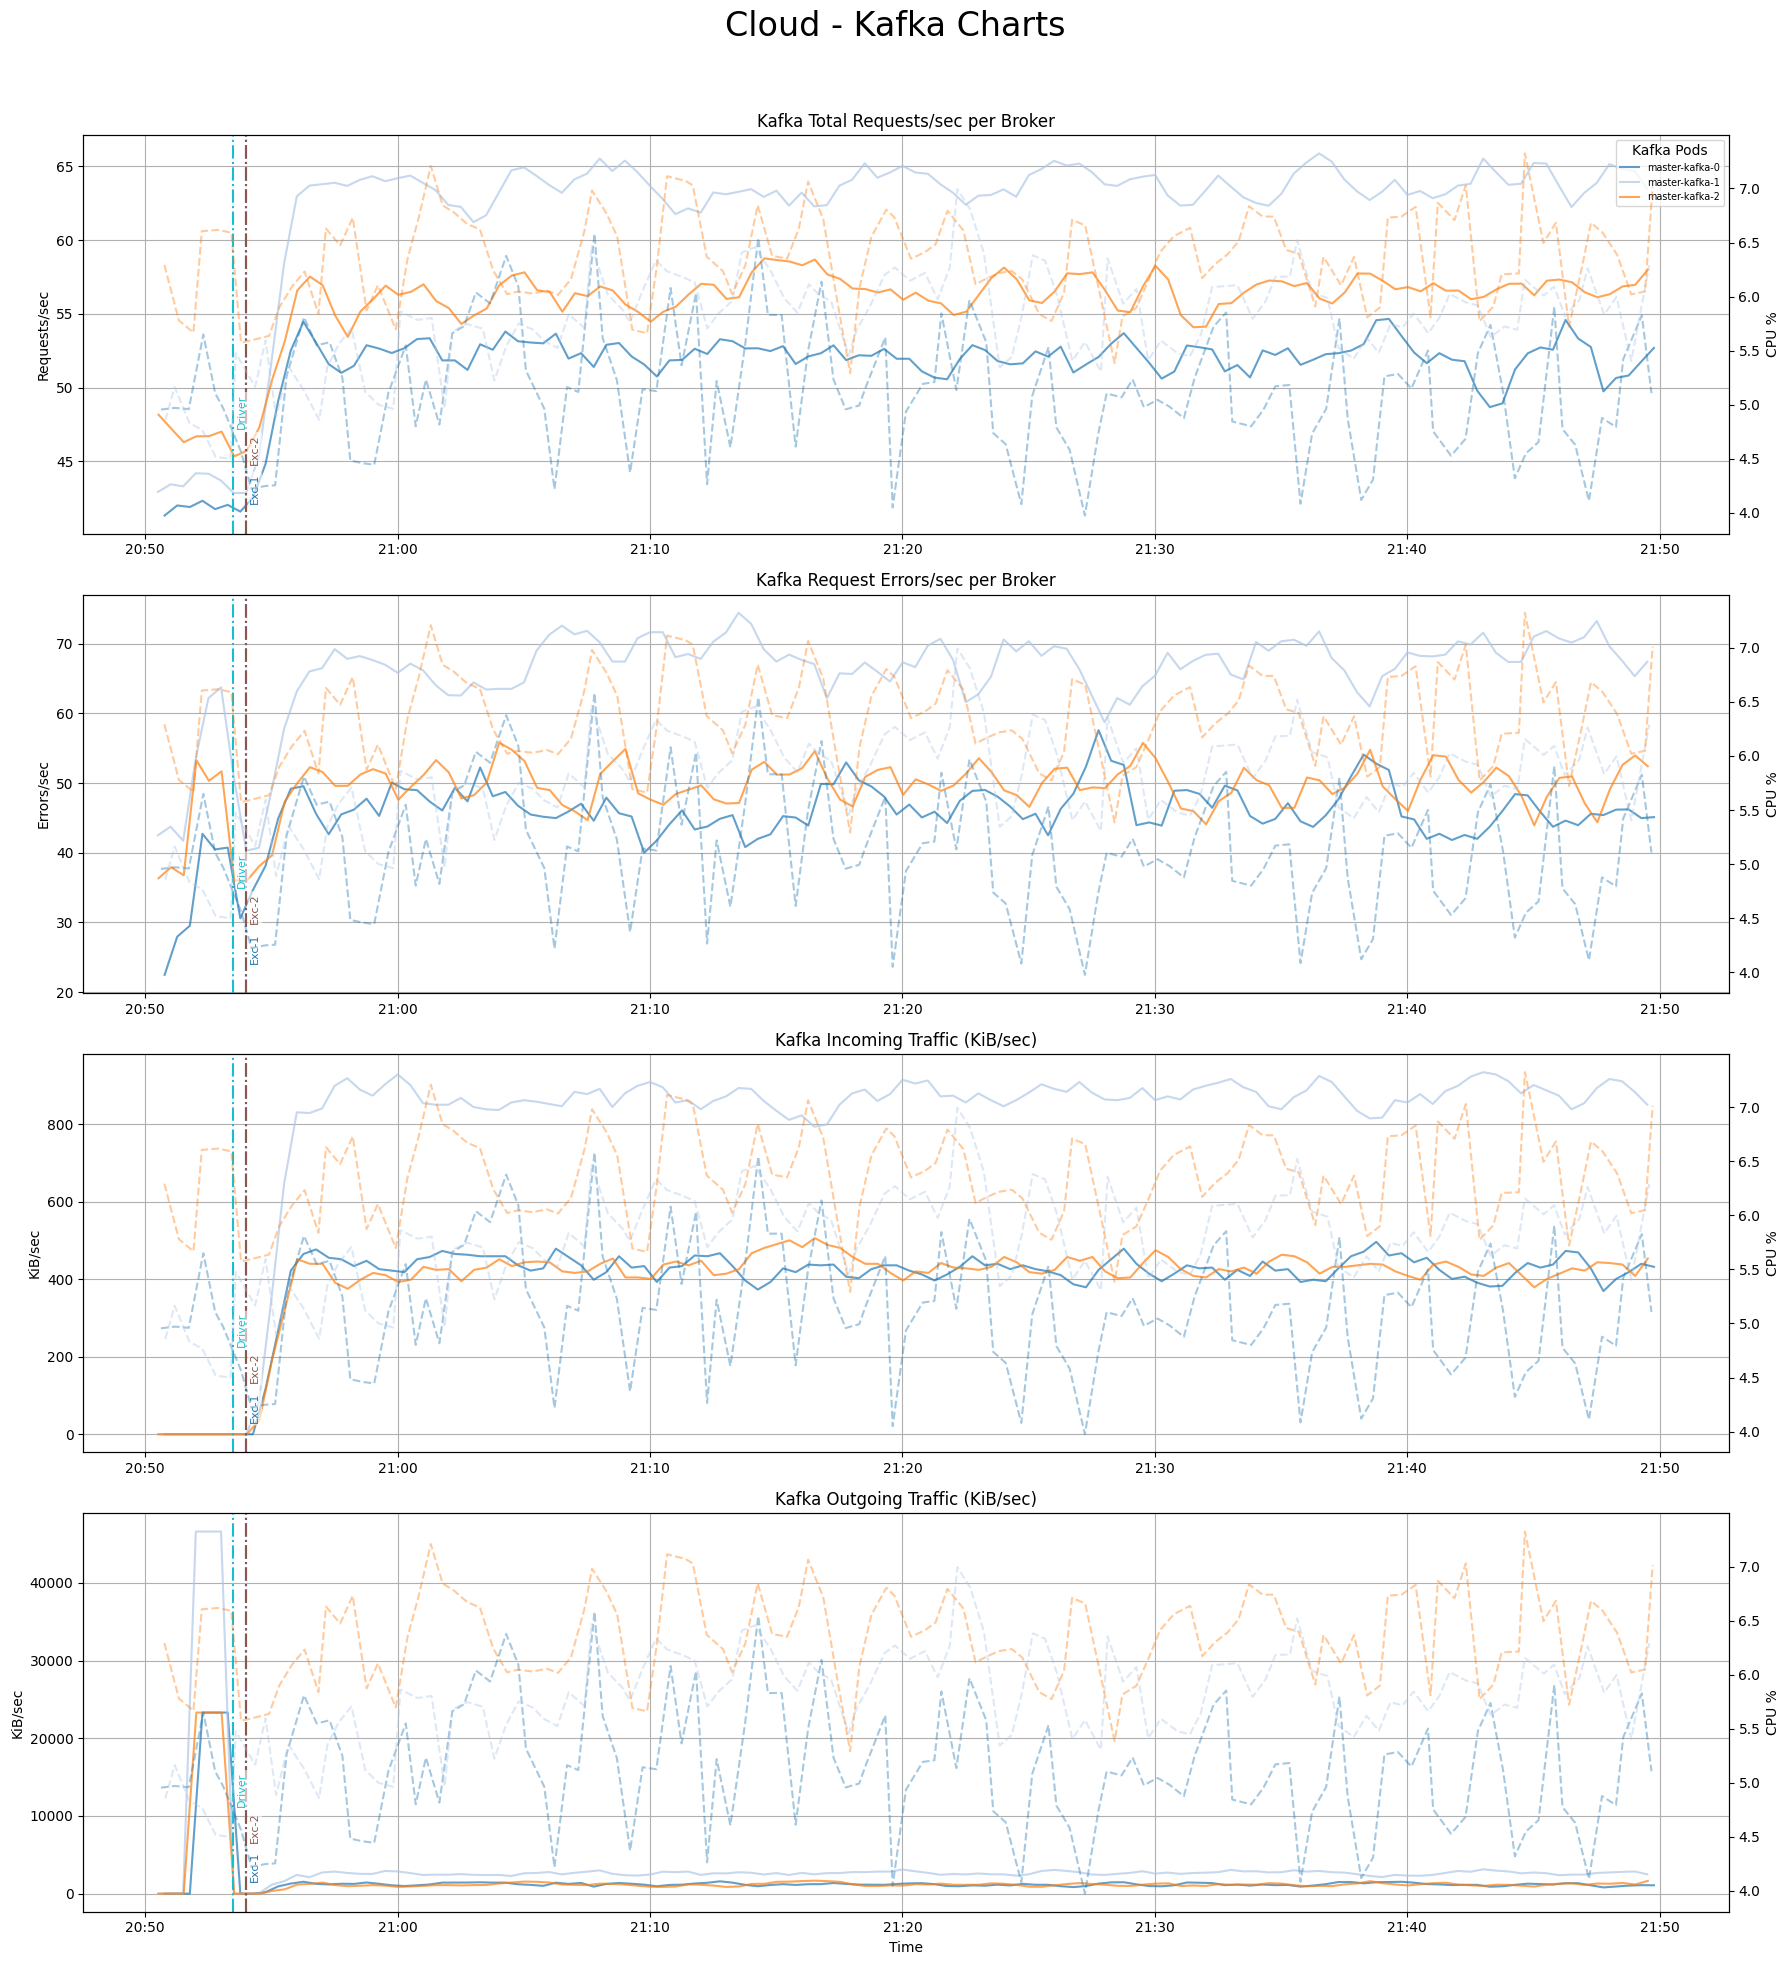

In [30]:
kafka_charts(kafka_bytes_in, kafka_bytes_out, kafka_requests, kafka_requests_errors, kafka_messages_in, df_container_cpu_usage_seconds_total, df_kube_pod_status_phase, title="Cloud - Kafka Charts")